In [1]:
# coding: utf-8
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy.mail import mail
from vnpy.trader.app.ctaStrategy.ctaTemplate import (CtaTemplate,
                                                     BarGenerator,
                                                     ArrayManager)

from collections import defaultdict
import numpy as np
import talib as ta
import pandas as pd
from datetime import datetime


class MultiSignalStrategy(CtaTemplate):
    className = 'MultiSignalStrategy'
    author = 'hy'

    # 策略交易标的
    symbol = EMPTY_STRING  
    posDict = {}  # 仓位数据缓存
    eveningDict = {}  # 可平仓量数据缓存
    bondDict = {}  # 保证金数据缓存

    # 策略参数
    amWindow = 19
    smaPeriod = 16
    lmaPeriod = 21
    svolmaPeriod=3
    lvolmaPeriod=19
    threshold = 2
    stopRatio = 0.02  # 止损比例

    # 策略变量
    initbars = 100  # 获取历史数据的条数
    posSize= 1
    flag = 0
#     longStop = 0                        # 多头止损
#     shortStop = 0                       # 空头止损
    Trend = 0
    transactionPrice = EMPTY_FLOAT  # 记录成交价格
    fixedSize = 1
    longStop = EMPTY_FLOAT
    shortStop = EMPTY_FLOAT

    # 参数列表，保存了参数的名称
    paramList = ['name',
                 'className',
                 'author',
                'amWindow',
                 'svolmaPeriod',
                 'lvolmaPeriod',
                 'smaPeriod',
                 'lmaPeriod',
                 'threshold',
                 'initbars',
                 'stopRatio',
                 'initDays']

    # 变量列表，保存了变量的名称
    varList = ['inited',
               'trading',
               'posDict',
               'posSize',
                'longStop',
               'shortStop',
               'transactionPrice',
               'fixedSize'
               ]

    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict',
                'eveningDict',
                'bondDict']

    # ----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        """Constructor"""
        super(MultiSignalStrategy, self).__init__(ctaEngine, setting)
        self.symbolList = setting['symbolList']

        self.OBV = 0
        self.VolSMA = 0
        self.MA = 0



        ###########################
        self.intradeHigh = 0
        self.intradeLow = 0
        # ----------------------------------------------------------------------

    def onInit(self):
        """初始化策略（必须由用户继承实现）"""
#         self.writeCtaLog(u'策略%s：初始化' % self.className)
        self.symbol = self.symbolList[0]

        # 构造K线合成器对象
        self.bgDict = {
            sym: BarGenerator(self.onBar)
            for sym in self.symbolList
        }
        
        self.amDict = {
            sym: ArrayManager()
            for sym in self.symbolList
        }

        self.bg30 = BarGenerator(self.onBar, 30, self.on30MinBar)
        self.bg30Dict = {
            sym: self.bg30
            for sym in self.symbolList
        }

        self.bg60 = BarGenerator(self.onBar, 60, self.on60MinBar)
        self.bg60Dict = {
            sym: self.bg60
            for sym in self.symbolList
        }

        # 生成Bar数组
        self.am30Dict = {
            sym: ArrayManager(size=self.lmaPeriod + 10)
            for sym in self.symbolList
        }

        self.am60Dict = {
            sym: ArrayManager(size=self.lmaPeriod + 10)
            for sym in self.symbolList
        }


        self.putEvent()
        '''
        在点击初始化策略时触发,载入历史数据,会推送到onbar去执行updatebar,但此时ctaEngine下单逻辑为False,不会触发下单.
        '''
#         pastbar15 = self.loadHistoryBar(self.symbol,'15min',1000)[:-80]
#         pastbar60 = self.loadHistoryBar(self.symbol,'60min',1000)[:-20]
#         pastbar1 = self.loadHistoryBar(self.symbol,'1min',1200)

#         for bar15 in pastbar15:
#             self.am15Dict[self.symbol].updateBar(bar15)

#         for bar60 in pastbar60:
#             self.am60Dict[self.symbol].updateBar(bar60)

#         for bar1 in pastbar1:
#             self.onBar(bar1)

    # ----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
#         self.writeCtaLog(u'策略%s：启动' % self.className)
        # self.ctaEngine.loadSyncData(self)    # 加载当前正确的持仓
        self.putEvent()
        '''
        在点击启动策略时触发,此时的ctaEngine会将下单逻辑改为True,此时开始推送到onbar的数据会触发下单.
        '''

    # ----------------------------------------------------------------------
    def onStop(self):
        """停止策略（必须由用户继承实现）"""
#         self.writeCtaLog(u'策略%s：停止' % self.className)
        self.putEvent()

    # ----------------------------------------------------------------------
    def onRestore(self):
        """从错误状态恢复策略（必须由用户集成实现）"""
#         self.writeCtaLog(u'策略%s：恢复策略状态成功' % self.Name)
        self.putEvent()
    
    # ----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        self.bgDict[tick.vtSymbol].updateTick(tick)
        pass

    # ----------------------------------------------------------------------
    def onBar(self, bar):
        """收到1分钟K线推送"""
        self.cancelAll()
        # 基于60分钟判断趋势过滤，因此先更新

        bg60 = self.bg60Dict[self.symbol]
        bg60.updateBar(bar)

        # 基于15分钟判断
        bg30 = self.bg30Dict[self.symbol]
        bg30.updateBar(bar)

#         # 洗价器
#         if (self.posDict[self.symbol+"_LONG"] > 0):
#             if (bar.close < self.transactionPrice * (1 - self.stopRatio)) or (
#                     bar.close > self.transactionPrice * (1 + 2 * self.stopRatio)):
#                 self.cancelAll()
#                 self.sell(self.symbol, bar.close*0.98, self.fixedSize, marketPrice="0")
# #                 self.writeCtaLog('平多仓 止盈或止损')
#         elif (self.posDict[self.symbol+"_SHORT"] > 0):
#             if (bar.close > self.transactionPrice * (1 + self.stopRatio)) or (
#                     bar.close < self.transactionPrice * (1 - 2 * self.stopRatio)):
#                 self.cancelAll()
#                 self.cover(self.symbol, bar.close*1.02 , self.fixedSize,marketPrice="0")
# #                 self.writeCtaLog('平空仓 止盈或止损')
        
        # 移动止损和固定止盈洗价器-2018年9月1日 17:12:22
        # if (self.posDict[self.symbol+"_LONG"] > 0):
        #     # 多头移动止损和固定止盈
        #     self.intraTradeHigh = max(self.intraTradeHigh, bar.high)
        #     self.intraTradeLow = bar.low
        #     self.longStop = self.intraTradeHigh*(1-self.stopRatio)
        #     self.lone_exit = self.transactionPrice * (1 + 2 * self.stopRatio)
        #     self.writeCtaLog('多头止损价格:%s'%self.longStop)
        #     self.writeCtaLog('多头止盈价格:%s'%self.lone_exit)           
        #     if bar.close<=self.longStop:
        #         self.cancelAll()
        #         self.sell(self.symbol, bar.close*0.98, self.fixedSize)
        #     self.writeCtaLog('移动止损出场，出场价格为:%s' %self.transactionPrice)

        # elif self.posDict[self.symbol+"_SHORT"] >0:
        #     self.intraTradeLow = min(self.intraTradeLow, bar.low)
        #     self.intraTradeHigh = bar.high
        #     self.shortStop = self.intraTradeLow*(1+self.stopRatio)
        #     self.shortexit = self.transactionPrice * (1 - 2* self.stopRatio)
        #     self.writeCtaLog('空头止损价格:%s' % self.shortStop)
        #     self.writeCtaLog('空头止盈价格:%s' % self.shortexit)
        #     if bar.close>=self.shortStop:
        #         self.cancelAll()
        #         self.cover(self.symbol, bar.close*1.02, self.fixedSize)
        #     self.writeCtaLog('移动止损出场，出场价格为:%s' % self.transactionPrice)
        
        if (self.posDict[self.symbol+"_LONG"] > 0):
            if (bar.close<self.transactionPrice*(1-self.stopRatio)) or (bar.close>self.transactionPrice*(1+3*self.stopRatio)):
                self.cancelAll()
                self.sell(self.symbol,bar.close*0.9, 1)
        elif (self.posDict[self.symbol+"_SHORT"] > 0):
            if (bar.close>self.transactionPrice*(1+self.stopRatio)) or  (bar.close<self.transactionPrice*(1-3*self.stopRatio)):
                self.cancelAll()
                self.cover(self.symbol,bar.close*1.1, 1)
                
        self.putEvent()

        # ----------------------------------------------------------------------
    def on30MinBar(self, bar):
            """60分钟K线推送"""

            am30 = self.am30Dict[self.symbol]
            am30.updateBar(bar)

            if not am30.inited:
                return

            obv =ta.AD(am30.high,am30.low,am30.close,am30.volume)
        
            if obv[-1]>obv[-2] and am30.close[-1]<am30.close[-2]:
                self.OBV = 1
            elif obv[-1]<obv[-2] and am30.close[-1]>am30.close[-2]:
                self.OBV = -1
            else:
                self.OBV = 0
            
            self.putEvent()
            # ----------------------------------------------------------------------
    def on60MinBar(self, bar):
            """收到Bar推送（必须由用户继承实现）"""
            self.cancelAll()

            am60 = self.am60Dict[self.symbol]
            am60.updateBar(bar)
            if not am60.inited:
                return

            
#                # 洗价器------------------------------------------------------------------------------------
#             if (self.posDict[self.symbol+"_LONG"] > 0):
#                 if (bar.close<self.transactionPrice*(1-self.stopRatio)):
#                     self.sell(self.symbol,bar.close*0.98,self.fixedSize)
#                     self.stopLosslong = 1
#                     self.stopLong = bar.datetime
#                 elif (bar.close>self.transactionPrice*(1+1.25*self.stopRatio)):
#                     self.sell(self.symbol,bar.close*0.98,self.fixedSize)
            
#             elif (self.posDict[self.symbol+"_SHORT"] > 0):
#                 if (bar.close>self.transactionPrice*(1+self.stopRatio)):
#                     self.stopLossshort = 1
#                     self.cover(self.symbol,bar.close*1.02,self.fixedSize)
#                     self.stopShort = bar.datetime
#                 elif (bar.close<self.transactionPrice*(1-1.25*self.stopRatio)):
#                     self.cover(self.symbol,bar.close*1.02,self.fixedSize)
                
                # self.putEvent()
        
        
    
            
            
    # 指标计算   
    #---------------------------------------------------------------------------
            
            
            VolSMA5 = ta.MA(am60.volume, self.svolmaPeriod)
            VolSMA10 = ta.MA(am60.volume, self.lvolmaPeriod)
            VolSMA=(VolSMA5+VolSMA10)/2
        
            if am60.volume[-2]>VolSMA[-2]:
                self.Vol = 1
            elif am60.volume[-2]<VolSMA[-2]:
                self.Vol = -1
            else:
                self.Vol = 0
            
            MA5 = ta.MA(am60.close, self.smaPeriod)
            MA20 = ta.MA(am60.close, self.lmaPeriod)
      #  print(MA5)
        
            if MA5[-2]>MA20[-2]:
                self.MA = 1
            elif MA5[-2]<MA20[-2]:
                self.MA = -1
            else:
                self.MA = 0
        
            Signal = self.MA+self.OBV+self.Vol

            if Signal>=2:
                if (self.posDict[self.symbol+"_LONG"]==0) and (self.posDict[self.symbol+"_SHORT"]==0):
                    self.buy(self.symbol,bar.close*1.1, self.fixedSize)
                elif self.posDict[self.symbol+"_SHORT"] > 0:
                    self.cancelAll()
                    self.cover(self.symbol,bar.close*1.1, self.posDict[self.symbol+"_SHORT"])
                    self.buy(self.symbol,bar.close*1.1, self.fixedSize)
            
            elif Signal<=-2:
                if (self.posDict[self.symbol+"_LONG"]==0) and (self.posDict[self.symbol+"_SHORT"]==0):
                    self.short(self.symbol,bar.close*0.9, self.fixedSize)
                elif self.posDict[self.symbol+"_LONG"]>0:
                    self.cancelAll()
                    self.sell(self.symbol,bar.close*0.9, self.fixedSize)
                    self.short(self.symbol,bar.close*0.9, self.fixedSize)
                  
                
      
            
                    self.putEvent()
            



            # ----------------------------------------------------------------------



    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""

        self.putEvent()

    # ----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交信息变化推送"""
        #print("\n\n\n\n stg onTrade", trade.vtSymbol)
        self.transactionPrice = trade.price
        print('trade direction',trade.direction,'offset',trade.offset,'price',trade.price, trade.dt)

#         self.writeCtaLog('onTrade price:%s'%trade.price)
        # self.saveSyncData()
        pass

    # ---------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass


# EOS品种  binance数据

In [2]:
if __name__=="__main__":
    from vnpy.trader.app.ctaStrategy.ctaBacktesting import BacktestingEngine, OptimizationSetting, MINUTE_DB_NAME
    # 创建回测引擎对象
    engine = BacktestingEngine()
    # 设置回测使用的数据
    engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
    engine.setDatabase(MINUTE_DB_NAME)  # 设置使用的历史数据库
    engine.setStartDate('20171231',initDays=1)               # 设置回测用的数据起始日期
    engine.setEndDate('20180907')
    
    # 配置回测引擎参数
    engine.setSlippage(0.0002)     # 设置滑点为股指1跳
    engine.setRate(5/10000)   # 设置手续费万0.3
    engine.setSize(100)     # 设置期货合约大小 100美金
    # engine.setPriceTick(0.0001)    # 设置价格变动
    engine.setCapital(100000)  
    # # 在引擎中创建策略对象
    d = {'symbolList':['EOSUSDT:binance']}          # 策略参数配置 tBTCUSD:bitfinex   BTCUSDT:binance
    engine.initStrategy(MultiSignalStrategy, d)    # 创建策略对象
#     test = open('log.txt','w') 
    engine.runBacktesting()
#     test.close()

仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0} 
可平仓量: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
2018-09-09 18:43:41.260261	开始回测
2018-09-09 18:43:41.260261	策略初始化
2018-09-09 18:43:41.260261	载入历史数据。数据范围:[20171230,20171231)
2018-09-09 18:43:41.283901	策略初始化完成
2018-09-09 18:43:41.284400	策略启动完成
2018-09-09 18:43:41.284897	开始回放回测数据,回测范围:[20171231,20180908)
2018-09-09 18:43:41.286394	载入历史数据。数据范围:[20171231,20180908)
2018-09-09 18:44:06.652231	载入完成，数据量：146378
2018-09-09 18:44:06.652730	当前回放数据:[20171231,20180908)
trade direction 空 offset 开仓 price 11.47 2018-05-29 19:01:00
trade direction 多 offset 平仓 price 11.7697 2018-05-29 19:27:00
trade direction 空 offset 开仓 price 11.8305 2018-05-29 20:01:00
trade direction 多 offset 平仓 price 12.074 2018-05-30 01:56:00
trade direction 空 offset 开仓 price 12.2799 2018-05-30 03:01:00
trade direction 多 offset 平仓 price 12.2019 2018-05-30 04:01:00
trade direction 多 offset 开仓 price 12.2019 2018-05-30 04:01:00
trade direction 空 offset

trade direction 多 offset 平仓 price 10.4383 2018-06-16 21:02:00
trade direction 空 offset 开仓 price 10.2839 2018-06-17 00:01:00
trade direction 多 offset 平仓 price 10.4986 2018-06-17 00:45:00
trade direction 空 offset 开仓 price 10.6873 2018-06-17 01:01:00
trade direction 多 offset 平仓 price 10.642 2018-06-17 18:01:00
trade direction 多 offset 开仓 price 10.642 2018-06-17 18:01:00
trade direction 空 offset 平仓 price 10.4273 2018-06-17 20:43:00
trade direction 空 offset 开仓 price 10.544 2018-06-18 00:01:00
trade direction 多 offset 平仓 price 10.8174 2018-06-19 01:13:00
trade direction 多 offset 开仓 price 10.6997 2018-06-19 05:01:00
trade direction 空 offset 平仓 price 10.48 2018-06-19 10:49:00
trade direction 多 offset 开仓 price 10.5177 2018-06-19 13:01:00
trade direction4:07.471672	Progress: 22%     空 offset 平仓 price 10.555 2018-06-20 03:01:00
trade direction 空 offset 开仓 price 10.555 2018-06-20 03:01:00
trade direction 多 offset 平仓 price 10.6696 2018-06-20 08:01:00
trade direction 多 offset 开仓 price 10.6696 2018-0

trade direction 多 offset 平仓 price 7.0859 2018-07-13 08:18:00
trade direction 多 offset 开仓 price 7.0904 2018-07-13 13:01:00
trade direction 空 offset 平仓 price 6.9313 2018-07-14 03:11:00
trade direction 多 offset 开仓 price 6.8827 2018-07-14 04:01:00
trade direction 空 offset 平仓 price 6.727 2018-07-14 04:04:00
trade direction 空 offset 开仓 price 6.9 2018-07-14 08:01:00
trade direction 多 offset 平仓 price 7.0651 2018-07-15 00:08:00
trade direction 多 offset 开仓 price 7.0129 2018-07-15 02:01:00
trade direction 空 offset 平仓 price 6.8556 2018-07-15 02:42:00
trade direction 多 offset 开仓 price 6.9018 2018-07-15 03:01:00
trade direction 空 offset 平仓 price 7.1202 2018-07-15 19:01:00
trade direction 空 offset 开仓 price 7.1202 2018-07-15 19:01:00
trade direction 多 offset 平仓 price 7.0932 2018-07-15 21:01:00
trade direction 多 offset 开仓 price 7.0932 2018-07-15 21:01:00
trade direction 空 offset 平仓 price 7.5205 2018-07-16 06:05:00
trade direction 多 offset 开仓 price 7.4008 2018-07-16 08:01:00
trade direction 空 offset 平仓 

trade direction 空 offset 开仓 price 5.4116 2018-08-09 01:01:00
trade direction 多 offset 平仓 price 5.5313 2018-08-09 01:36:00
trade direction 空 offset 开仓 price 5.6203 2018-08-09 05:01:00
trade direction 多 offset 平仓 price 5.7441 2018-08-09 14:10:00
trade direction 空 offset 开仓 price 5.737 2018-08-09 15:01:00
trade direction 多 offset 平仓 price 5.7842 2018-08-09 22:01:00
trade direction 多 offset 开仓 price 5.7842 2018-08-09 22:01:00
trade direction 空 offset 平仓 price 5.6458 2018-08-10 10:19:00
trade direction 多 offset 开仓 price 5.6726 2018-08-10 11:01:00
trade direction 空 offset 平仓 price 5.5461 2018-08-10 16:18:00
trade direction 多 offset 开仓 price 5.5034 2018-08-10 17:01:00
trade direction 空 offset 平仓 price 5.5385 2018-08-10 19:01:00
trade direction 空 offset 开仓 price 5.5385 2018-08-10 19:01:00
trade direction 多 offset 平仓 price 5.6558 2018-08-10 20:56:00
trade direction 空 offset 开仓 price 5.507 2018-08-10 23:01:00
trade direction 多 offset 平仓 price 5.6181 2018-08-10 23:47:00
trade direction 空 offset 开

trade direction 多 offset 开仓 price 6.7114 2018-09-01 18:01:00
trade direction 空 offset 平仓 price 6.5691 2018-09-02 08:46:00
trade direction 多 offset 开仓 price 6.4244 2018-09-02 10:01:00
trade direction 空 offset 平仓 price 6.6023 2018-09-02 12:01:00
trade direction 空 offset 开仓 price 6.6023 2018-09-02 12:01:00
trade direction 多 offset 平仓 price 6.5314 2018-09-03 16:01:00
trade direction 多 offset 开仓 price 6.5314 2018-09-03 16:01:00
trade direction 空 offset 平仓 price 6.4 2018-09-03 17:43:00
trade direction 多 offset 开仓 price 6.4116 2018-09-03 18:01:00
trade direction 空 offset 平仓 price 6.4029 2018-09-03 20:01:00
trade direction 空 offset 开仓 price 6.4029 2018-09-03 20:01:00
trade direction 多 offset 平仓 price 6.5383 2018-09-04 03:51:00
trade direction 空 offset 开仓 price 6.5562 2018-09-04 04:01:00
trade direction 多 offset 平仓 price 6.3947 2018-09-04 14:01:00
trade direction 多 offset 开仓 price 6.3947 2018-09-04 14:01:00
trade direction 空 offset 平仓 price 6.5661 2018-09-04 23:01:00
trade direction 空 offset 开仓

In [3]:
# 显示前10条成交记录
for i in range(40):
    d = engine.tradeDict[str(i+1)].__dict__
    print('TradeID: %s, Time: %s, Direction: %s, Price: %s, Volume: %s' %(d['tradeID'], d['dt'], d['direction'], d['price'], d['volume']))

TradeID: 1, Time: 2018-05-29 19:01:00, Direction: 空, Price: 11.47, Volume: 1
TradeID: 2, Time: 2018-05-29 19:27:00, Direction: 多, Price: 11.7697, Volume: 1
TradeID: 3, Time: 2018-05-29 20:01:00, Direction: 空, Price: 11.8305, Volume: 1
TradeID: 4, Time: 2018-05-30 01:56:00, Direction: 多, Price: 12.074, Volume: 1
TradeID: 5, Time: 2018-05-30 03:01:00, Direction: 空, Price: 12.2799, Volume: 1
TradeID: 6, Time: 2018-05-30 04:01:00, Direction: 多, Price: 12.2019, Volume: 1
TradeID: 7, Time: 2018-05-30 04:01:00, Direction: 多, Price: 12.2019, Volume: 1
TradeID: 8, Time: 2018-05-30 06:49:00, Direction: 空, Price: 11.9504, Volume: 1
TradeID: 9, Time: 2018-05-30 11:01:00, Direction: 多, Price: 12.2799, Volume: 1
TradeID: 10, Time: 2018-05-30 22:48:00, Direction: 空, Price: 12.0037, Volume: 1
TradeID: 11, Time: 2018-05-30 23:01:00, Direction: 多, Price: 11.795, Volume: 1
TradeID: 12, Time: 2018-05-31 03:01:00, Direction: 空, Price: 11.7826, Volume: 1
TradeID: 13, Time: 2018-05-31 03:01:00, Direction: 空,

2018-09-09 18:44:10.679490	计算按日统计结果
2018-09-09 18:44:10.723405	------------------------------
2018-09-09 18:44:10.723405	首个交易日：	2018-05-28
2018-09-09 18:44:10.723405	最后交易日：	2018-09-07
2018-09-09 18:44:10.723405	总交易日：	103
2018-09-09 18:44:10.723904	盈利交易日	51
2018-09-09 18:44:10.723904	亏损交易日：	51
2018-09-09 18:44:10.723904	起始资金：	100000
2018-09-09 18:44:10.723904	结束资金：	101,052.93
2018-09-09 18:44:10.723904	总收益率：	1.05%
2018-09-09 18:44:10.723904	年化收益：	2.45%
2018-09-09 18:44:10.723904	总盈亏：	1,052.93
2018-09-09 18:44:10.723904	最大回撤: 	-171.84
2018-09-09 18:44:10.723904	百分比最大回撤: -0.17%
2018-09-09 18:44:10.724403	总手续费：	236.44
2018-09-09 18:44:10.724403	总滑点：	11.38
2018-09-09 18:44:10.724403	总成交金额：	472,886.75
2018-09-09 18:44:10.724403	总成交笔数：	569
2018-09-09 18:44:10.724403	日均盈亏：	10.22
2018-09-09 18:44:10.724403	日均手续费：	2.3
2018-09-09 18:44:10.724403	日均滑点：	0.11
2018-09-09 18:44:10.724403	日均成交金额：	4,591.13
2018-09-09 18:44:10.724901	日均成交笔数：	5.52
2018-09-09 18:44:10.724901	日均收益率：	0.01%
2018-09-09 18:44:1

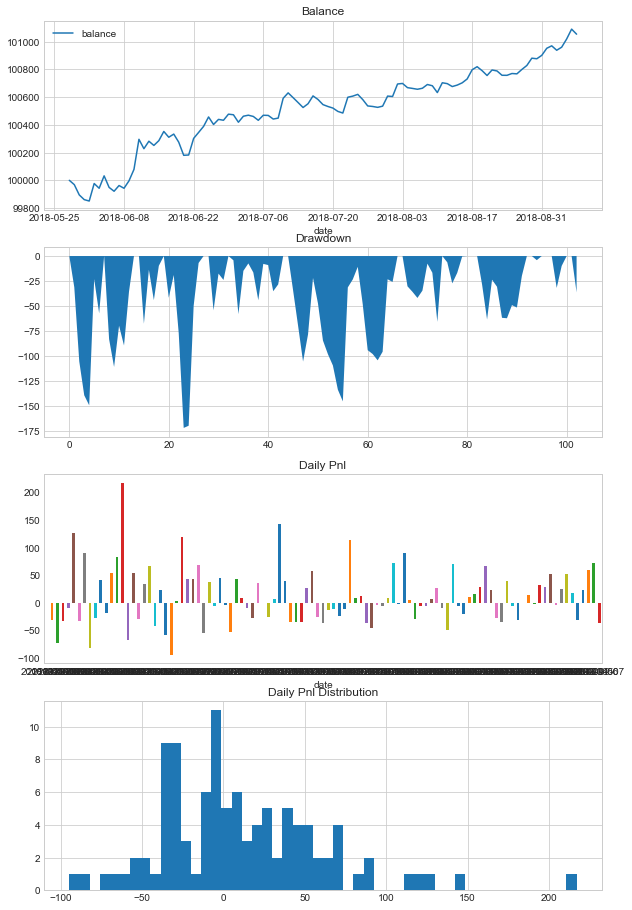

2018-09-09 18:44:12.677689	计算回测结果
单笔盈亏： -2.7529032258064485 入场时间： 2018-05-29 19:01:00 开仓价： 11.47 出场时间 2018-05-29 19:27:00 平仓价： 11.7697 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.1982392967330133 入场时间： 2018-05-29 20:01:00 开仓价： 11.8305 出场时间 2018-05-30 01:56:00 平仓价： 12.074 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 0.49518432560525255 入场时间： 2018-05-30 03:01:00 开仓价： 12.2799 出场时间 2018-05-30 04:01:00 平仓价： 12.2019 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.201154410378712 入场时间： 2018-05-30 04:01:00 开仓价： 12.2019 出场时间 2018-05-30 06:49:00 平仓价： 11.9504 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.389203983745791 入场时间： 2018-05-30 11:01:00 开仓价： 12.2799 出场时间 2018-05-30 22:48:00 平仓价： 12.0037 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -0.2451292920729082 入场时间： 2018-05-30 23:01:00 开仓价： 11.795 出场时间 2018-05-31 03:01:00 平仓价： 11.7826 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.0080087586780544 入场时间： 2018-05-31 03:01:00 开仓价： 11.7826 出场时间 2018-05-31 08:22:00 平仓价： 12.0027 交易数量： -1 合约面值： 100 滑点： 0.04 手续费：

单笔盈亏： -2.1574779176846346 入场时间： 2018-06-17 18:01:00 开仓价： 10.642 出场时间 2018-06-17 20:43:00 平仓价： 10.4273 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.7329438543247226 入场时间： 2018-06-18 00:01:00 开仓价： 10.544 出场时间 2018-06-19 01:13:00 平仓价： 10.8174 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.193328597998071 入场时间： 2018-06-19 05:01:00 开仓价： 10.6997 出场时间 2018-06-19 10:49:00 平仓价： 10.48 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 0.21464027306350356 入场时间： 2018-06-19 13:01:00 开仓价： 10.5177 出场时间 2018-06-20 03:01:00 平仓价： 10.555 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -1.2257413548081588 入场时间： 2018-06-20 03:01:00 开仓价： 10.555 出场时间 2018-06-20 08:01:00 平仓价： 10.6696 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.6536837369723347 入场时间： 2018-06-20 08:01:00 开仓价： 10.6696 出场时间 2018-06-20 09:02:00 平仓价： 10.4014 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -1.3242206939185561 入场时间： 2018-06-20 10:01:00 开仓价： 10.3528 出场时间 2018-06-20 14:01:00 平仓价： 10.2302 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.719617211784712 入场时间： 2

单笔盈亏： -0.09994270593091435 入场时间： 2018-07-29 16:01:00 开仓价： 8.2382 出场时间 2018-07-29 21:01:00 平仓价： 8.2415 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -0.7709531031972288 入场时间： 2018-07-29 21:01:00 开仓价： 8.2415 出场时间 2018-07-30 00:01:00 平仓价： 8.2935 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -0.9128944354012157 入场时间： 2018-07-30 00:01:00 开仓价： 8.2935 出场时间 2018-07-30 01:01:00 平仓价： 8.2294 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.2373582521204365 入场时间： 2018-07-30 01:01:00 开仓价： 8.2294 出场时间 2018-07-30 07:28:00 平仓价： 8.402 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 1.3329891956782716 入场时间： 2018-07-30 08:01:00 开仓价： 8.33 出场时间 2018-07-30 12:01:00 平仓价： 8.2073 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -0.5518284941454484 入场时间： 2018-07-30 12:01:00 开仓价： 8.2073 出场时间 2018-07-30 18:01:00 平仓价： 8.1735 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 6.153509512448781 入场时间： 2018-07-30 18:01:00 开仓价： 8.1735 出场时间 2018-07-31 01:36:00 平仓价： 7.6591 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 5.849583333333333 入场时间： 2018-07-31 0

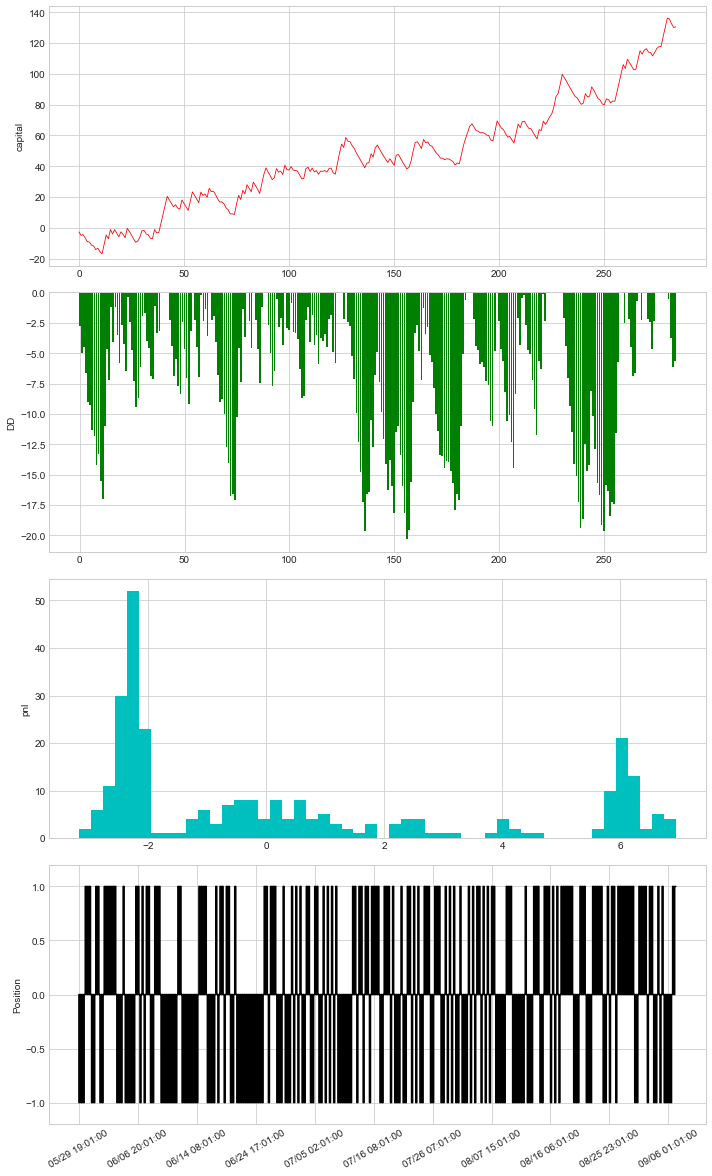

In [4]:
# 显示逐日回测结果
engine.showDailyResult()
# 显示逐笔回测结果
engine.showBacktestingResult()

In [5]:
engine.calculateBacktestingResult()

2018-09-09 18:44:15.647541	计算回测结果
单笔盈亏： -2.7529032258064485 入场时间： 2018-05-29 19:01:00 开仓价： 11.47 出场时间 2018-05-29 19:27:00 平仓价： 11.7697 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.1982392967330133 入场时间： 2018-05-29 20:01:00 开仓价： 11.8305 出场时间 2018-05-30 01:56:00 平仓价： 12.074 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 0.49518432560525255 入场时间： 2018-05-30 03:01:00 开仓价： 12.2799 出场时间 2018-05-30 04:01:00 平仓价： 12.2019 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.201154410378712 入场时间： 2018-05-30 04:01:00 开仓价： 12.2019 出场时间 2018-05-30 06:49:00 平仓价： 11.9504 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.389203983745791 入场时间： 2018-05-30 11:01:00 开仓价： 12.2799 出场时间 2018-05-30 22:48:00 平仓价： 12.0037 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -0.2451292920729082 入场时间： 2018-05-30 23:01:00 开仓价： 11.795 出场时间 2018-05-31 03:01:00 平仓价： 11.7826 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.0080087586780544 入场时间： 2018-05-31 03:01:00 开仓价： 11.7826 出场时间 2018-05-31 08:22:00 平仓价： 12.0027 交易数量： -1 合约面值： 100 滑点： 0.04 手续费：

单笔盈亏： -2.49793887233809 入场时间： 2018-07-05 02:01:00 开仓价： 9.063 出场时间 2018-07-05 06:56:00 平仓价： 8.8493 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 0.8887280159924494 入场时间： 2018-07-05 08:01:00 开仓价： 8.9042 出场时间 2018-07-05 16:01:00 平仓价： 8.9958 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.4099481980479798 入场时间： 2018-07-05 16:01:00 开仓价： 8.9958 出场时间 2018-07-05 19:07:00 平仓价： 9.2 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 2.102192465073758 入场时间： 2018-07-05 20:01:00 开仓价： 8.9689 出场时间 2018-07-06 02:01:00 平仓价： 8.7678 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -0.23124295718423232 入场时间： 2018-07-06 02:01:00 开仓价： 8.7678 出场时间 2018-07-06 05:01:00 平仓价： 8.7598 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 0.5495134592113925 入场时间： 2018-07-06 05:01:00 开仓价： 8.7598 出场时间 2018-07-07 09:01:00 平仓价： 8.6994 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -1.0032779272133805 入场时间： 2018-07-07 09:01:00 开仓价： 8.6994 出场时间 2018-07-07 16:01:00 平仓价： 8.6243 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 2.31005391741938 入场时间： 2018-07-07 16:01:0

单笔盈亏： 2.360323039152352 入场时间： 2018-08-15 17:01:00 开仓价： 4.6434 出场时间 2018-08-16 06:01:00 平仓价： 4.7595 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 2.667017543859657 入场时间： 2018-08-16 06:01:00 开仓价： 4.7595 出场时间 2018-08-16 09:01:00 平仓价： 4.6259 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 1.8466404375364958 入场时间： 2018-08-16 09:01:00 开仓价： 4.6259 出场时间 2018-08-16 18:01:00 平仓价： 4.7178 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 4.5507456865488205 入场时间： 2018-08-16 18:01:00 开仓价： 4.7178 出场时间 2018-08-17 06:01:00 平仓价： 4.4965 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 6.743131324363391 入场时间： 2018-08-17 06:01:00 开仓价： 4.4965 出场时间 2018-08-17 10:52:00 平仓价： 4.806 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 1.855569916072251 入场时间： 2018-08-17 15:01:00 开仓价： 4.9209 出场时间 2018-08-17 17:01:00 平仓价： 4.8227 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 5.931287867791895 入场时间： 2018-08-17 17:01:00 开仓价： 4.8227 出场时间 2018-08-18 00:38:00 平仓价： 5.1155 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 6.575132963458963 入场时间： 2018-08-18 03:01:00 开

{'capital': 130.52089121737492,
 'maxCapital': 136.19247878631563,
 'drawdown': -5.6715875689407085,
 'totalResult': 285,
 'totalTurnover': 57000,
 'totalCommission': 28.500000000000135,
 'totalSlippage': 11.399999999999933,
 'timeList': [Timestamp('2018-05-29 19:27:00'),
  Timestamp('2018-05-30 01:56:00'),
  Timestamp('2018-05-30 04:01:00'),
  Timestamp('2018-05-30 06:49:00'),
  Timestamp('2018-05-30 22:48:00'),
  Timestamp('2018-05-31 03:01:00'),
  Timestamp('2018-05-31 08:22:00'),
  Timestamp('2018-05-31 19:01:00'),
  Timestamp('2018-06-01 13:47:00'),
  Timestamp('2018-06-01 19:01:00'),
  Timestamp('2018-06-02 11:31:00'),
  Timestamp('2018-06-02 14:01:00'),
  Timestamp('2018-06-02 16:23:00'),
  Timestamp('2018-06-02 18:36:00'),
  Timestamp('2018-06-02 19:53:00'),
  Timestamp('2018-06-03 00:41:00'),
  Timestamp('2018-06-03 04:59:00'),
  Timestamp('2018-06-03 20:01:00'),
  Timestamp('2018-06-03 20:39:00'),
  Timestamp('2018-06-03 21:32:00'),
  Timestamp('2018-06-04 03:01:00'),
  Times

# EOS品种 bitfinex数据

In [15]:
if __name__=="__main__":
    from vnpy.trader.app.ctaStrategy.ctaBacktesting import BacktestingEngine, OptimizationSetting, MINUTE_DB_NAME
    # 创建回测引擎对象
    engine = BacktestingEngine()
    # 设置回测使用的数据
    engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
    engine.setDatabase(MINUTE_DB_NAME)  # 设置使用的历史数据库
    engine.setStartDate('20170701',initDays=1)               # 设置回测用的数据起始日期
    engine.setEndDate('20180907')
    
    # 配置回测引擎参数
    engine.setSlippage(0.0002)     # 设置滑点为股指1跳
    engine.setRate(5/10000)   # 设置手续费万0.3
    engine.setSize(100)     # 设置期货合约大小 100美金
    # engine.setPriceTick(0.0001)    # 设置价格变动
    engine.setCapital(100000)  
    # # 在引擎中创建策略对象
    d = {'symbolList':['tEOSUSD:bitfinex']}          # 策略参数配置 tBTCUSD:bitfinex   BTCUSDT:binance
    engine.initStrategy(MultiSignalStrategy, d)    # 创建策略对象
#     test = open('log.txt','w') 
    engine.runBacktesting()
#     test.close()

仓位字典构造完成 
初始仓位: {'tEOSUSD:bitfinex_LONG': 0, 'tEOSUSD:bitfinex_SHORT': 0} 
可平仓量: {'tEOSUSD:bitfinex_LONG': 0, 'tEOSUSD:bitfinex_SHORT': 0}
2018-09-09 19:36:42.639109	开始回测
2018-09-09 19:36:42.639109	策略初始化
2018-09-09 19:36:42.639109	载入历史数据。数据范围:[20170630,20170701)
2018-09-09 19:36:42.662068	策略初始化完成
2018-09-09 19:36:42.662068	策略启动完成
2018-09-09 19:36:42.662068	开始回放回测数据,回测范围:[20170701,20180908)
2018-09-09 19:36:42.665560	载入历史数据。数据范围:[20170701,20180908)
2018-09-09 19:38:09.962568	载入完成，数据量：559402
2018-09-09 19:38:09.962568	当前回放数据:[20170701,20180908)
trade direction 多 offset 开仓 price 3.3109 2017-07-03 13:01:00
trade direction 空 offset 平仓 price 3.5787 2017-07-03 13:20:00
trade direction 多 offset 开仓 price 4.67 2017-07-03 16:01:00
trade direction 空 offset 平仓 price 4.5003 2017-07-03 16:02:00
trade direction 多 offset 开仓 price 4.89 2017-07-03 17:01:00
trade direction 空 offset 平仓 price 5.197 2017-07-03 17:16:00
trade direction 多 offset 开仓 price 4.3 2017-07-03 19:01:00
trade direction 空 offset 平仓 pric

trade direction 多 offset 平仓 price 1.6159 2017-07-12 00:19:00
trade direction 空 offset 开仓 price 1.5997 2017-07-12 01:01:00
trade direction 多 offset 平仓 price 1.6134 2017-07-12 01:17:00
trade direction 空 offset 开仓 price 1.614 2017-07-12 02:01:00
trade direction 多 offset 平仓 price 1.5 2017-07-12 03:21:00
trade direction 空 offset 开仓 price 1.478 2017-07-12 04:01:00
trade direction 多 offset 平仓 price 1.5001 2017-07-12 04:14:00
trade direction 多 offset 开仓 price 1.4324 2017-07-12 10:01:00
trade direction 空 offset 平仓 price 1.401 2017-07-12 10:19:00
trade direction 空 offset 开仓 price 1.5919 2017-07-12 13:01:00
trade direction 多 offset 平仓 price 1.6311 2017-07-12 16:33:00
trade direction 空 offset 开仓 price 1.651 2017-07-12 17:01:00
trade direction 多 offset 平仓 price 1.6774 2017-07-12 17:40:00
trade direction 空 offset 开仓 price 1.65 2017-07-12 21:01:00
trade direction 多 offset 平仓 price 1.6862 2017-07-13 00:15:00
trade direction 多 offset 开仓 price 1.9995 2017-07-13 02:01:00
trade direction 空 offset 平仓 price

trade direction 多 offset 开仓 price 1.8299 2017-07-23 20:01:00
trade direction 空 offset 平仓 price 1.9446 2017-07-23 22:09:00
trade direction 多 offset 开仓 price 1.935 2017-07-23 23:01:00
trade direction 空 offset 平仓 price 1.9382 2017-07-24 00:02:00
trade direction 空 offset 开仓 price 1.9382 2017-07-24 00:02:00
trade direction 多 offset 平仓 price 1.9774 2017-07-24 03:21:00
trade direction 空 offset 开仓 price 1.9784 2017-07-24 04:02:00
trade direction 多 offset 平仓 price 1.858 2017-07-24 13:29:00
trade direction 多 offset 开仓 price 1.8551 2017-07-24 14:01:00
trade direction 空 offset 平仓 price 1.8896 2017-07-24 21:01:00
trade direction 空 offset 开仓 price 1.8896 2017-07-24 21:01:00
trade direction 多 offset 平仓 price 1.7622 2017-07-25 14:47:00
trade direction 空 offset 开仓 price 1.7921 2017-07-25 15:02:00
trade direction 多 offset 平仓 price 1.683 2017-07-25 18:37:00
trade direction 空 offset 开仓 price 1.6299 2017-07-25 19:01:00
trade direction 多 offset 平仓 price 1.6659 2017-07-25 20:21:00
trade direction 空 offset 开仓

trade direction 空 offset 平仓 price 1.8625 2017-08-11 15:01:00
trade direction 空 offset 开仓 price 1.8625 2017-08-11 15:01:00
trade direction 多 offset 平仓 price 1.74 2017-08-12 07:04:00
trade direction 空 offset 开仓 price 1.8058 2017-08-12 10:01:00
trade direction 多 offset 平仓 price 1.6803 2017-08-13 01:47:00
trade direction 空 offset 开仓 price 1.7019 2017-08-13 02:01:00
trade direction 多 offset 平仓 price 1.5813 2017-08-13 08:58:00
trade direction 空 offset 开仓 price 1.6171 2017-08-13 09:01:00
trade direction 多 offset 平仓 price 1.617 2017-08-13 12:12:00
trade direction 空 offset 开仓 price 1.632 2017-08-13 15:01:00
trade direction 多 offset 平仓 price 1.668 2017-08-13 22:21:00
trade direction 空 offset 开仓 price 1.5839 2017-08-14 01:02:00
trade direction 多 offset 平仓 price 1.6015 2017-08-14 05:20:00
trade direction 空 offset 开仓 price 1.6233 2017-08-14 06:01:00
trade direction 多 offset 平仓 price 1.6582 2017-08-14 11:31:00
trade direction 多 offset 开仓 price 1.6571 2017-08-14 16:01:00
trade direction 空 offset 平仓 p

trade direction 多 offset 平仓 price 1.1819 2017-09-04 15:47:00
trade direction 空 offset 开仓 price 1.077 2017-09-04 19:01:00
trade direction 多 offset 平仓 price 1.012 2017-09-04 19:55:00
trade direction 空 offset 开仓 price 1.0198 2017-09-04 20:01:00
trade direction 多 offset 平仓 price 0.9485 2017-09-04 20:16:00
trade direction 空 offset 开仓 price 0.8995 2017-09-04 23:01:00
trade direction 多 offset 平仓 price 0.8449 2017-09-04 23:17:00
trade direction 空 offset 开仓 price 0.9604 2017-09-05 04:01:00
trade direction 多 offset 平仓 price 0.9883 2017-09-05 04:02:00
trade direction 空 offset 开仓 price 1.0127 2017-09-05 05:01:00
trade direction 多 offset 平仓 price 0.9482 2017-09-05 07:02:00
trade direction 空 offset 开仓 price 0.9127 2017-09-05 08:01:00
trade direction 多 offset 平仓 price 0.9299 2017-09-05 08:15:00
trade direction 空 offset 开仓 price 0.90439 2017-09-05 09:01:00
trade direction 多 offset 平仓 price 0.849 2017-09-05 09:30:00
trade direction 空 offset 开仓 price 0.7782 2017-09-05 10:01:00
trade direction 多 offset 平

trade direction 空 offset 开仓 price 0.66113 2017-09-15 23:01:00
trade direction 多 offset 平仓 price 0.6199 2017-09-16 00:38:00
trade direction 空 offset 开仓 price 0.63735 2017-09-16 02:01:00
trade direction 多 offset 平仓 price 0.65 2017-09-16 03:25:00
trade direction 空 offset 开仓 price 0.6549 2017-09-16 04:01:00
trade direction 多 offset 平仓 price 0.66689 2017-09-16 04:08:00
trade direction 空 offset 开仓 price 0.6687 2017-09-16 07:01:00
trade direction 多 offset 平仓 price 0.626 2017-09-16 18:04:00
trade direction 多 offset 开仓 price 0.60969 2017-09-16 23:02:00
trade direction 空 offset 平仓 price 0.60285 2017-09-16 23:08:00
trade direction 空 offset 开仓 price 0.63 2017-09-17 03:03:00
trade direction 多 offset 平仓 price 0.59 2017-09-17 12:16:00
trade direction 空 offset 开仓 price 0.5879 2017-09-17 13:01:00
trade direction 多 offset 平仓 price 0.6018 2017-09-17 17:54:00
trade direction 空 offset 开仓 price 0.58992 2017-09-17 20:01:00
trade direction 多 offset 平仓 price 0.605 2017-09-17 21:24:00
trade direction 空 offset 开

trade direction 空 offset 开仓 price 0.57011 2017-10-10 14:01:00
trade direction 多 offset 平仓 price 0.5804 2017-10-10 16:28:00
trade direction 空 offset 开仓 price 0.5736 2017-10-10 17:01:00
trade direction 多 offset 平仓 price 0.5597 2017-10-11 06:01:00
trade direction 多 offset 开仓 price 0.5597 2017-10-11 06:01:00
trade direction 空 offset 平仓 price 0.5574 2017-10-11 17:01:00
trade direction 空 offset 开仓 price 0.5574 2017-10-11 17:01:00
trade direction 多 offset 平仓 price 0.57129 2017-10-11 22:03:00
trade direction 空 offset 开仓 price 0.5777 2017-10-11 23:01:00
trade direction 多 offset 平仓 price 0.589 2017-10-12 02:40:00
trade direction 多 offset 开仓 price 0.59604 2017-10-12 04:01:00
trade direction 空 offset 平仓 price 0.58247 2017-10-12 17:18:00
trade direction 多 offset 开仓 price 0.62085 2017-10-12 20:01:00
trade direction 空 offset 平仓 price 0.6119 2017-10-13 01:23:00
trade direction 空 offset 开仓 price 0.61635 2017-10-13 02:01:00
trade direction 多 offset 平仓 price 0.5793 2017-10-13 08:11:00
trade direction 多 o

trade direction 多 offset 开仓 price 1.345 2017-11-03 20:01:00
trade direction 空 offset 平仓 price 1.3185 2017-11-03 20:07:00
trade direction 空 offset 开仓 price 1.2497 2017-11-03 22:01:00
trade direction 多 offset 平仓 price 1.28 2017-11-03 22:22:00
trade direction 多 offset 开仓 price 1.278 2017-11-03 23:01:00
trade direction 空 offset 平仓 price 1.3551 2017-11-04 00:16:00
trade direction 多 offset 开仓 price 1.1979 2017-11-04 08:01:00
trade direction 空 offset 平仓 price 1.1663 2017-11-04 08:15:00
trade direction 多 offset 开仓 price 1.1908 2017-11-04 09:01:00
trade direction 空 offset 平仓 price 1.1619 2017-11-04 12:01:00
trade direction 空 offset 开仓 price 1.1814 2017-11-04 13:01:00
trade direction 多 offset 平仓 price 1.2118 2017-11-04 13:31:00
trade direction 空 offset 开仓 price 1.2003 2017-11-04 14:01:00
trade direction 多 offset 平仓 price 1.2269 2017-11-04 14:33:00
trade direction 空 offset 开仓 price 1.2728 2017-11-04 15:01:00
trade direction 多 offset 平仓 price 1.192 2017-11-04 19:10:00
trade direction 空 offset 开仓 p

trade direction 多 offset 开仓 price 1.859 2017-11-16 19:01:00
trade direction 空 offset 平仓 price 1.818 2017-11-16 19:06:00
trade direction 多 offset 开仓 price 1.7758 2017-11-16 23:01:00
trade direction 空 offset 平仓 price 1.7566 2017-11-17 01:24:00
trade direction 多 offset 开仓 price 1.766 2017-11-17 03:01:00
trade direction 空 offset 平仓 price 1.7269 2017-11-17 06:51:00
trade direction 多 offset 开仓 price 1.6311 2017-11-17 09:01:00
trade direction 空 offset 平仓 price 1.723 2017-11-17 10:42:00
trade direction 空 offset 开仓 price 1.7088 2017-11-17 13:02:00
trade direction 多 offset 平仓 price 1.744 2017-11-17 13:32:00
trade direction 空 offset 开仓 price 1.7469 2017-11-17 14:01:00
trade direction 多 offset 平仓 price 1.7801 2017-11-17 14:33:00
trade direction 空 offset 开仓 price 1.78 2017-11-17 15:01:00
trade direction 多 offset 平仓 price 1.6718 2017-11-17 15:35:00
trade direction 空 offset 开仓 price 1.68 2017-11-17 18:01:00
trade direction 多 offset 平仓 price 1.715 2017-11-17 23:20:00
trade direction 空 offset 开仓 price 

trade direction 多 offset 平仓 price 2.7686 2017-11-30 18:53:00
trade direction 空 offset 开仓 price 2.7812 2017-11-30 20:01:00
trade direction 多 offset 平仓 price 2.5803 2017-11-30 21:35:00
trade direction 空 offset 开仓 price 2.54 2017-11-30 22:01:00
trade direction 多 offset 平仓 price 2.6044 2017-11-30 22:20:00
trade direction 多 offset 开仓 price 2.5652 2017-12-01 00:01:00
trade direction 空 offset 平仓 price 2.6651 2017-12-01 03:01:00
trade direction 空 offset 开仓 price 2.6651 2017-12-01 03:01:00
trade direction 多 offset 平仓 price 2.7199 2017-12-01 03:20:00
trade direction 空 offset 开仓 price 2.7716 2017-12-01 04:01:00
trade direction 多 offset 平仓 price 2.61 2017-12-01 05:18:00
trade direction 空 offset 开仓 price 2.689 2017-12-01 06:01:00
trade direction 多 offset 平仓 price 2.75 2017-12-01 06:18:00
trade direction 空 offset 开仓 price 2.7649 2017-12-01 07:01:00
trade direction 多 offset 平仓 price 2.835 2017-12-01 07:24:00
trade direction 空 offset 开仓 price 2.754 2017-12-01 10:01:00
trade direction 多 offset 平仓 price

trade direction 多 offset 平仓 price 3.75 2017-12-10 09:08:00
trade direction 空 offset 开仓 price 3.6986 2017-12-10 10:01:00
trade direction 多 offset 平仓 price 3.78 2017-12-10 10:15:00
trade direction 空 offset 开仓 price 3.7367 2017-12-10 15:01:00
trade direction 多 offset 平仓 price 3.5287 2017-12-10 20:24:00
trade direction 空 offset 开仓 price 3.607 2017-12-10 21:01:00
trade direction 多 offset 平仓 price 3.6878 2017-12-10 21:16:00
trade direction 空 offset 开仓 price 3.7822 2017-12-11 00:01:00
trade direction 多 offset 平仓 price 3.8667 2017-12-11 08:53:00
trade direction 多 offset 开仓 price 3.978 2017-12-11 11:01:00
trade direction 空 offset 平仓 price 3.86 2017-12-11 11:48:00
trade direction 多 offset 开仓 price 3.9284 2017-12-11 13:01:00
trade direction 空 offset 平仓 price 3.8603 2017-12-11 19:27:00
trade direction 多 offset 开仓 price 3.965 2017-12-11 21:01:00
trade direction 空 offset 平仓 price 4.2045 2017-12-11 23:29:00
trade direction 多 offset 开仓 price 4.205 2017-12-12 01:01:00
trade direction 空 offset 平仓 price 

trade direction 多 offset 开仓 price 11.032 2017-12-21 20:01:00
trade direction 空 offset 平仓 price 10.833 2017-12-21 22:13:00
trade direction 多 offset 开仓 price 10.182 2017-12-22 00:01:00
trade direction 空 offset 平仓 price 10.799 2017-12-22 04:07:00
trade direction 空 offset 开仓 price 10.744 2017-12-22 06:01:00
trade direction 多 offset 平仓 price 10.099 2017-12-22 08:41:00
trade direction 空 offset 开仓 price 9.969 2017-12-22 09:01:00
trade direction 多 offset 平仓 price 10.22 2017-12-22 09:23:00
trade direction 空 offset 开仓 price 9.73 2017-12-22 10:01:00
trade direction 多 offset 平仓 price 9.9726 2017-12-22 10:30:00
trade direction 空 offset 开仓 price 8.6586 2017-12-22 15:01:00
trade direction 多 offset 平仓 price 8.0994 2017-12-22 15:12:00
trade direction 空 offset 开仓 price 8.591 2017-12-22 19:01:00
trade direction 多 offset 平仓 price 7.9999 2017-12-22 20:55:00
trade direction 空 offset 开仓 price 8.03 2017-12-22 21:01:00
trade direction 多 offset 平仓 price 7.4349 2017-12-22 21:06:00
trade direction 空 offset 开仓 pri

trade direction 多 offset 开仓 price 7.74 2018-01-01 02:01:00
trade direction 空 offset 平仓 price 7.5652 2018-01-01 08:07:00
trade direction 多 offset 开仓 price 7.48 2018-01-01 09:01:00
trade direction 空 offset 平仓 price 7.3173 2018-01-01 09:59:00
trade direction 多 offset 开仓 price 7.8 2018-01-01 18:01:00
trade direction 空 offset 平仓 price 7.6287 2018-01-01 19:07:00
trade direction 多 offset 开仓 price 7.4798 2018-01-01 21:01:00
trade direction 空 offset 平仓 price 7.2999 2018-01-01 22:06:00
trade direction 空 offset 开仓 price 7.507 2018-01-02 02:02:00
trade direction 多 offset 平仓 price 7.6593 2018-01-02 04:09:00
trade direction 多 offset 开仓 price 7.82 2018-01-02 06:01:00
trade direction 空 offset 平仓 price 7.67 2018-01-02 07:50:00
trade direction 空 offset 开仓 price 8.1531 2018-01-02 13:01:00
trade direction 多 offset 平仓 price 7.92 2018-01-02 20:01:00
trade direction 多 offset 开仓 price 7.92 2018-01-02 20:01:00
trade direction 空 offset 平仓 price 8.3999 2018-01-03 05:27:00
trade direction 空 offset 开仓 price 8.3541

trade direction 多 offset 平仓 price 13.609 2018-01-14 20:12:00
trade direction 空 offset 开仓 price 13.5 2018-01-14 21:01:00
trade direction 多 offset 平仓 price 13.867 2018-01-14 21:09:00
trade direction 空 offset 开仓 price 13.316 2018-01-15 00:01:00
trade direction 多 offset 平仓 price 13.591 2018-01-15 00:10:00
trade direction 空 offset 开仓 price 14.141 2018-01-15 03:01:00
trade direction 多 offset 平仓 price 13.3 2018-01-15 07:40:00
trade direction 空 offset 开仓 price 13.733 2018-01-15 11:01:00
trade direction 多 offset 平仓 price 14.026 2018-01-15 11:58:00
trade direction 空 offset 开仓 price 14.138 2018-01-15 13:01:00
trade direction 多 offset 平仓 price 14.426 2018-01-15 14:10:00
trade direction 空 offset 开仓 price 14.634 2018-01-15 15:01:00
trade direction 多 offset 平仓 price 13.75 2018-01-15 19:30:00
trade direction 多 offset 开仓 price 14.2 2018-01-15 21:01:00
trade direction 空 offset 平仓 price 13.905 2018-01-16 01:59:00
trade direction 多 offset 开仓 price 13.891 2018-01-16 02:01:00
trade direction 空 offset 平仓 pri

trade direction 空 offset 开仓 price 12.292 2018-01-23 23:01:00
trade direction 多 offset 平仓 price 12.618 2018-01-23 23:15:00
trade direction 空 offset 开仓 price 13.28 2018-01-24 00:01:00
trade direction 多 offset 平仓 price 13.566 2018-01-24 00:29:00
trade direction 空 offset 开仓 price 13.511 2018-01-24 03:01:00
trade direction 多 offset 平仓 price 12.682 2018-01-24 08:38:00
trade direction 空 offset 开仓 price 12.594 2018-01-24 09:01:00
trade direction 多 offset 平仓 price 12.88 2018-01-24 10:24:00
trade direction 空 offset 开仓 price 12.92 2018-01-24 11:01:00
trade direction 多 offset 平仓 price 13.2 2018-01-24 11:34:00
trade direction 多 offset 开仓 price 13.06 2018-01-24 17:01:00
trade direction 空 offset 平仓 price 13.254 2018-01-24 20:01:00
trade direction 空 offset 开仓 price 13.254 2018-01-24 20:01:00
trade direction 多 offset 平仓 price 13.545 2018-01-24 20:49:00
trade direction 空 offset 开仓 price 13.169 2018-01-25 01:01:00
trade direction 多 offset 平仓 price 13.44 2018-01-25 03:48:00
trade direction 多 offset 开仓 pri

trade direction 多 offset 平仓 price 7.7409 2018-02-07 03:23:00
trade direction 多 offset 开仓 price 8.3 2018-02-07 06:01:00
trade direction 空 offset 平仓 price 8.1296 2018-02-07 06:04:00
trade direction 多 offset 开仓 price 8.1541 2018-02-07 09:01:00
trade direction 空 offset 平仓 price 7.9696 2018-02-07 10:39:00
trade direction 多 offset 开仓 price 7.92 2018-02-07 14:01:00
trade direction 空 offset 平仓 price 7.744 2018-02-07 14:12:00
trade direction 多 offset 开仓 price 8.769 2018-02-07 19:01:00
trade direction 空 offset 平仓 price 8.582 2018-02-07 19:16:00
trade direction 多 offset 开仓 price 8.612 2018-02-07 20:01:00
trade direction 空 offset 平仓 price 8.414 2018-02-07 22:27:00
trade direction 多 offset 开仓 price 8.55 2018-02-07 23:01:00
trade direction 空 offset 平仓 price 8.3831 2018-02-07 23:34:00
trade direction 多 offset 开仓 price 8.4031 2018-02-08 00:01:00
trade direction 空 offset 平仓 price 8.2312 2018-02-08 00:38:00
trade direction 多 offset 开仓 price 7.662 2018-02-08 08:01:00
trade direction 空 offset 平仓 price 8.1

trade direction 多 offset 平仓 price 7.755 2018-02-26 20:01:00
trade direction 多 offset 开仓 price 7.755 2018-02-26 20:01:00
trade direction 空 offset 平仓 price 8.2157 2018-02-27 00:03:00
trade direction 多 offset 开仓 price 8.1135 2018-02-27 02:01:00
trade direction 空 offset 平仓 price 7.9261 2018-02-27 09:38:00
trade direction 多 offset 开仓 price 8.0451 2018-02-27 12:01:00
trade direction 空 offset 平仓 price 8.552 2018-02-27 21:41:00
trade direction 多 offset 开仓 price 8.56 2018-02-27 23:01:00
trade direction 空 offset 平仓 price 8.3676 2018-02-27 23:20:00
trade direction 多 offset 开仓 price 8.4573 2018-02-28 00:02:00
trade direction 空 offset 平仓 price 8.98 2018-02-28 13:34:00
trade direction 多 offset 开仓 price 8.85 2018-02-28 15:01:00
trade direction 空 offset 平仓 price 8.661 2018-02-28 16:40:00
trade direction 多 offset 开仓 price 8.51 2018-02-28 20:01:00
trade direction 空 offset 平仓 price 8.3339 2018-03-01 06:38:00
trade direction 空 offset 开仓 price 8.1816 2018-03-01 08:01:00
trade direction 多 offset 平仓 price 8.

trade direction 空 offset 平仓 price 5.7348 2018-03-20 12:20:00
trade direction 多 offset 开仓 price 5.63 2018-03-20 14:01:00
trade direction 空 offset 平仓 price 5.5203 2018-03-20 15:56:00
trade direction 多 offset 开仓 price 5.7619 2018-03-20 19:01:00
trade direction 空 offset 平仓 price 6.1158 2018-03-21 00:58:00
trade direction 空 offset 开仓 price 6.0808 2018-03-21 03:01:00
trade direction 多 offset 平仓 price 6.21 2018-03-21 03:38:00
trade direction 空 offset 开仓 price 6.275 2018-03-21 04:01:00
trade direction 多 offset 平仓 price 5.8745 2018-03-21 07:44:00
trade direction 多 offset 开仓 price 5.9434 2018-03-21 08:01:00
trade direction 空 offset 平仓 price 6.3691 2018-03-21 23:22:00
trade direction 空 offset 开仓 price 6.2123 2018-03-22 00:01:00
trade direction 多 offset 平仓 price 6.37 2018-03-22 02:31:00
trade direction 多 offset 开仓 price 6.937 2018-03-22 07:01:00
trade direction 空 offset 平仓 price 6.773 2018-03-22 07:05:00
trade direction 多 offset 开仓 price 6.8982 2018-03-22 08:01:00
trade direction 空 offset 平仓 price

trade direction 多 offset 开仓 price 8.4018 2018-04-12 07:01:00
trade direction 空 offset 平仓 price 8.2101 2018-04-12 08:49:00
trade direction 多 offset 开仓 price 8.4227 2018-04-12 09:01:00
trade direction 空 offset 平仓 price 8.9955 2018-04-12 10:53:00
trade direction 多 offset 开仓 price 8.7816 2018-04-12 12:01:00
trade direction 空 offset 平仓 price 8.52691888 2018-04-12 14:34:00
trade direction 多 offset 开仓 price 9.1746 2018-04-12 21:01:00
trade direction 空 offset 平仓 price 8.9881 2018-04-12 21:35:00
trade direction 多 offset 开仓 price 9.1682 2018-04-13 12:01:00
trade direction 空 offset 平仓 price 8.9703 2018-04-13 13:57:00
trade direction 多 offset 开仓 price 9.1373 2018-04-13 15:01:00
trade direction 空 offset 平仓 price 9.2901 2018-04-13 17:01:00
trade direction 空 offset 开仓 price 9.2901 2018-04-13 17:01:00
trade direction 多 offset 平仓 price 9.1 2018-04-13 23:01:00
trade direction 多 offset 开仓 price 9.1 2018-04-13 23:01:00
trade direction 空 offset 平仓 price 8.9261 2018-04-14 04:44:00
trade direction 多 offset 开

trade direction 多 offset 开仓 price 15.211 2018-04-27 17:01:00
trade direction 空 offset 平仓 price 16.131 2018-04-27 18:14:00
trade direction 多 offset 开仓 price 16.484 2018-04-27 19:01:00
trade direction 空 offset 平仓 price 16.136 2018-04-27 19:17:00
trade direction 多 offset 开仓 price 16.202 2018-04-27 20:01:00
trade direction 空 offset 平仓 price 17.197 2018-04-27 22:59:00
trade direction 多 offset 开仓 price 17.022 2018-04-27 23:01:00
trade direction 空 offset 平仓 price 16.663 2018-04-28 04:37:00
trade direction 多 offset 开仓 price 17.6 2018-04-28 10:01:00
trade direction 空 offset 平仓 price 17.2 2018-04-28 10:56:00
trade direction 多 offset 开仓 price 17.256 2018-04-28 11:01:00
trade direction 空 offset 平仓 price 18.369 2018-04-28 14:35:00
trade direction 多 offset 开仓 price 18.286 2018-04-28 16:01:00
trade direction 空 offset 平仓 price 19.429 2018-04-28 22:09:00
trade direction 多 offset 开仓 price 18.93 2018-04-28 23:01:00
trade direction 空 offset 平仓 price 18.475 2018-04-28 23:08:00
trade direction 多 offset 开仓 p

trade direction 空 offset 平仓 price 14.217 2018-05-15 19:01:00
trade direction 空 offset 开仓 price 14.217 2018-05-15 19:01:00
trade direction 多 offset 平仓 price 13.332 2018-05-15 23:02:00
trade direction 空 offset 开仓 price 13.069 2018-05-16 02:01:00
trade direction 多 offset 平仓 price 12.282 2018-05-16 10:15:00
trade direction 空 offset 开仓 price 12.22 2018-05-16 13:01:00
trade direction 多 offset 平仓 price 12.49989896 2018-05-16 18:15:00
trade direction 空 offset 开仓 price 12.398 2018-05-16 21:01:00
trade direction 多 offset 平仓 price 12.666 2018-05-17 07:55:00
trade direction 多 offset 开仓 price 12.709 2018-05-17 08:01:00
trade direction 空 offset 平仓 price 13.509 2018-05-17 09:37:00
trade direction 多 offset 开仓 price 13.85 2018-05-17 10:01:00
trade direction 空 offset 平仓 price 13.566 2018-05-17 10:35:00
trade direction 多 offset 开仓 price 13.629 2018-05-17 11:01:00
trade direction 空 offset 平仓 price 13.318 2018-05-17 11:56:00
trade direction 多 offset 开仓 price 13.161 2018-05-17 18:01:00
trade direction 空 off

trade direction 多 offset 平仓 price 13.9 2018-06-05 16:47:00
trade direction 空 offset 开仓 price 13.853 2018-06-05 17:01:00
trade direction 多 offset 平仓 price 14.19 2018-06-06 00:18:00
trade direction 空 offset 开仓 price 14.084 2018-06-06 03:01:00
trade direction 多 offset 平仓 price 14.119 2018-06-06 10:01:00
trade direction 多 offset 开仓 price 14.119 2018-06-06 10:01:00
trade direction 空 offset 平仓 price 13.807 2018-06-06 13:13:00
trade direction 多 offset 开仓 price 13.94 2018-06-06 17:01:00
trade direction 空 offset 平仓 price 14.126 2018-06-06 21:01:00
trade direction 空 offset 开仓 price 14.126 2018-06-06 21:01:00
trade direction 多 offset 平仓 price 13.789 2018-06-07 19:01:00
trade direction 多 offset 开仓 price 13.789 2018-06-07 19:01:00
trade direction 空 offset 平仓 price 14.201 2018-06-08 05:01:00
trade direction 空 offset 开仓 price 14.201 2018-06-08 05:01:00
trade direction 多 offset 平仓 price 14.284 2018-06-08 06:01:00
trade direction 多 offset 开仓 price 14.284 2018-06-08 06:01:00
trade direction 空 offset 平仓 

trade direction 多 offset 平仓 price 7.323 2018-06-29 07:44:00
trade direction 空 offset 开仓 price 7.391 2018-06-29 08:01:00
trade direction 多 offset 平仓 price 7.5613 2018-06-30 06:25:00
trade direction 空 offset 开仓 price 7.839 2018-06-30 07:01:00
trade direction 多 offset 平仓 price 8.0166 2018-06-30 09:27:00
trade direction 多 offset 开仓 price 8.0851 2018-06-30 11:01:00
trade direction 空 offset 平仓 price 7.9168 2018-06-30 22:43:00
trade direction 多 offset 开仓 price 8.0027 2018-06-30 23:01:00
trade direction 空 offset 平仓 price 8.124 2018-07-01 08:01:00
trade direction 空 offset 开仓 price 8.124 2018-07-01 08:01:00
trade direction 多 offset 平仓 price 8.0138 2018-07-01 10:01:00
trade direction 多 offset 开仓 price 8.0138 2018-07-01 10:01:00
trade direction 空 offset 平仓 price 8.0479 2018-07-01 14:01:00
trade direction 空 offset 开仓 price 8.0479 2018-07-01 14:01:00
trade direction 多 offset 平仓 price 8.2214 2018-07-02 06:13:00
trade direction 空 offset 开仓 price 8.1572 2018-07-02 07:01:00
trade direction 多 offset 平仓 p

trade direction 空 offset 平仓 price 8.442 2018-07-27 05:02:00
trade direction 多 offset 开仓 price 8.3043 2018-07-27 06:01:00
trade direction 空 offset 平仓 price 8.1961 2018-07-27 09:01:00
trade direction 空 offset 开仓 price 8.1961 2018-07-27 09:01:00
trade direction 多 offset 平仓 price 8.3801 2018-07-27 23:25:00
trade direction 空 offset 开仓 price 8.3786 2018-07-28 00:01:00
trade direction 多 offset 平仓 price 8.5015 2018-07-28 07:01:00
trade direction 多 offset 开仓 price 8.5015 2018-07-28 07:01:00
trade direction 空 offset 平仓 price 8.3252 2018-07-28 11:23:00
trade direction 多 offset 开仓 price 8.3893 2018-07-28 13:01:00
trade direction 空 offset 平仓 price 8.2126 2018-07-28 22:00:00
trade direction 空 offset 开仓 price 8.2115 2018-07-28 22:01:00
trade direction 多 offset 平仓 price 8.3785 2018-07-29 08:01:00
trade direction 空 offset 开仓 price 8.2609 2018-07-29 13:02:00
trade direction 多 offset 平仓 price 8.2131 2018-07-29 18:01:00
trade direction 多 offset 开仓 price 8.2131 2018-07-29 18:01:00
trade direction 空 offset 

trade direction 空 offset 开仓 price 5.0966 2018-08-19 07:01:00
trade direction 多 offset 平仓 price 5.199 2018-08-19 17:08:00
trade direction 空 offset 开仓 price 5.095 2018-08-19 18:01:00
trade direction 多 offset 平仓 price 5.234 2018-08-19 19:09:00
trade direction 多 offset 开仓 price 5.2803 2018-08-19 21:01:00
trade direction 空 offset 平仓 price 5.1612 2018-08-19 23:23:00
trade direction 多 offset 开仓 price 5.282 2018-08-20 00:01:00
trade direction 空 offset 平仓 price 5.1714 2018-08-20 00:21:00
trade direction 多 offset 开仓 price 5.1198 2018-08-20 02:01:00
trade direction 空 offset 平仓 price 5.074 2018-08-20 17:01:00
trade direction 空 offset 开仓 price 5.074 2018-08-20 17:01:00
trade direction 多 offset 平仓 price 4.767 2018-08-21 06:19:00
trade direction 空 offset 开仓 price 4.7303 2018-08-21 07:01:00
trade direction 多 offset 平仓 price 4.83494218 2018-08-21 15:29:00
trade direction 空 offset 开仓 price 4.9 2018-08-21 17:01:00
trade direction 多 offset 平仓 price 4.8849 2018-08-22 07:01:00
trade direction 多 offset 开仓 pr

2018-09-09 19:38:24.524879	计算按日统计结果
2018-09-09 19:38:24.586263	------------------------------
2018-09-09 19:38:24.586263	首个交易日：	2017-07-02
2018-09-09 19:38:24.586263	最后交易日：	2018-09-07
2018-09-09 19:38:24.586263	总交易日：	433
2018-09-09 19:38:24.586263	盈利交易日	231
2018-09-09 19:38:24.586263	亏损交易日：	201
2018-09-09 19:38:24.586263	起始资金：	100000
2018-09-09 19:38:24.586263	结束资金：	104,191.27
2018-09-09 19:38:24.586762	总收益率：	4.19%
2018-09-09 19:38:24.586762	年化收益：	2.32%
2018-09-09 19:38:24.586762	总盈亏：	4,191.27
2018-09-09 19:38:24.586762	最大回撤: 	-429.5
2018-09-09 19:38:24.586762	百分比最大回撤: -0.42%
2018-09-09 19:38:24.586762	总手续费：	1,103.99
2018-09-09 19:38:24.586762	总滑点：	69.46
2018-09-09 19:38:24.586762	总成交金额：	2,207,989.79
2018-09-09 19:38:24.586762	总成交笔数：	3,473
2018-09-09 19:38:24.586762	日均盈亏：	9.68
2018-09-09 19:38:24.587261	日均手续费：	2.55
2018-09-09 19:38:24.587261	日均滑点：	0.16
2018-09-09 19:38:24.587261	日均成交金额：	5,099.28
2018-09-09 19:38:24.587261	日均成交笔数：	8.02
2018-09-09 19:38:24.587261	日均收益率：	0.01%
2018-09-09 

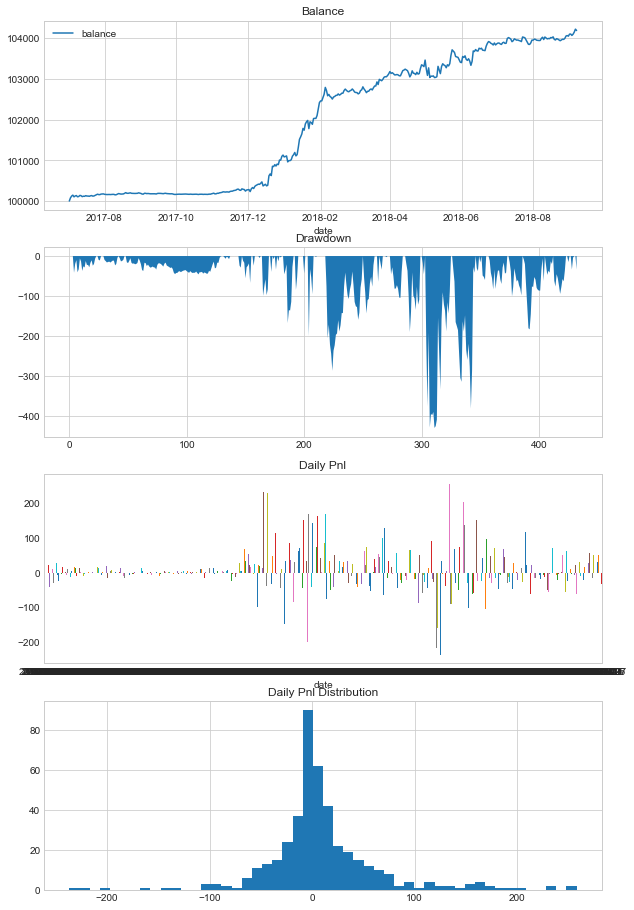

2018-09-09 19:38:28.813724	计算回测结果
单笔盈亏： 7.948435168685246 入场时间： 2017-07-03 13:01:00 开仓价： 3.3109 出场时间 2017-07-03 13:20:00 平仓价： 3.5787 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -3.773832976445391 入场时间： 2017-07-03 16:01:00 开仓价： 4.67 出场时间 2017-07-03 16:02:00 平仓价： 4.5003 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 6.138118609406962 入场时间： 2017-07-03 17:01:00 开仓价： 4.89 出场时间 2017-07-03 17:16:00 平仓价： 5.197 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.202790697674424 入场时间： 2017-07-03 19:01:00 开仓价： 4.3 出场时间 2017-07-03 19:04:00 平仓价： 4.2113 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 5.500037945209422 入场时间： 2017-07-03 20:01:00 开仓价： 3.4787 出场时间 2017-07-03 20:13:00 平仓价： 3.6749 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 7.365524244606098 入场时间： 2017-07-03 21:01:00 开仓价： 4.0277 出场时间 2017-07-03 21:10:00 平仓价： 4.33 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -0.05828132728328369 入场时间： 2017-07-04 03:01:00 开仓价： 4.6501 出场时间 2017-07-04 03:06:00 平仓价： 4.6539 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -1.8543994625395055 

单笔盈亏： -2.57066375818011 入场时间： 2017-07-17 09:01:00 开仓价： 1.2836 出场时间 2017-07-17 09:26:00 平仓价： 1.3148 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.199040590405907 入场时间： 2017-07-17 10:01:00 开仓价： 1.355 出场时间 2017-07-17 14:13:00 平仓价： 1.3829 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.99714285714286 入场时间： 2017-07-17 15:01:00 开仓价： 1.4 出场时间 2017-07-17 15:26:00 平仓价： 1.44 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 0.4795001759943624 入场时间： 2017-07-17 16:01:00 开仓价： 1.4205 出场时间 2017-07-17 16:43:00 平仓价： 1.4293 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -4.14574300071788 入场时间： 2017-07-17 18:01:00 开仓价： 1.393 出场时间 2017-07-17 19:03:00 平仓价： 1.3372 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 2.6037920799247116 入场时间： 2017-07-17 22:01:00 开仓价： 1.3813 出场时间 2017-07-17 23:14:00 平仓价： 1.4192 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 6.363244412400869 入场时间： 2017-07-18 00:01:00 开仓价： 1.387 出场时间 2017-07-18 02:44:00 平仓价： 1.4772 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.917017783857727 入场时间： 2017-07-18 03:01:00 开仓价： 1

单笔盈亏： -1.7452139279464098 入场时间： 2017-08-14 16:01:00 开仓价： 1.6571 出场时间 2017-08-14 17:08:00 平仓价： 1.6305 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 3.884442935621267 入场时间： 2017-08-14 18:01:00 开仓价： 1.6201 出场时间 2017-08-14 23:01:00 平仓价： 1.5549 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.3523609235320593 入场时间： 2017-08-14 23:01:00 开仓价： 1.5549 出场时间 2017-08-14 23:23:00 平仓价： 1.5205 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 3.9588939492518 入场时间： 2017-08-15 00:01:00 开仓价： 1.537 出场时间 2017-08-15 03:01:00 平仓价： 1.6 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.264999999999988 入场时间： 2017-08-15 03:01:00 开仓价： 1.6 出场时间 2017-08-15 08:09:00 平仓价： 1.634 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.2410253506951063 入场时间： 2017-08-15 11:01:00 开仓价： 1.5897 出场时间 2017-08-15 13:44:00 平仓价： 1.6231 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.174866424703993 入场时间： 2017-08-15 14:01:00 开仓价： 1.6807 出场时间 2017-08-15 14:13:00 平仓价： 1.7149 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -1.8126190476190487 入场时间： 2017-08-15 19:01:00 开

单笔盈亏： -2.451046850586514 入场时间： 2017-09-13 08:01:00 开仓价： 0.85762 出场时间 2017-09-13 08:25:00 平仓价： 0.8378 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -4.2320716112532 入场时间： 2017-09-13 11:01:00 开仓价： 0.782 出场时间 2017-09-13 11:29:00 平仓价： 0.75 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.4868962644077253 入场时间： 2017-09-13 12:01:00 开仓价： 0.7201 出场时间 2017-09-13 12:35:00 平仓价： 0.737 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 5.888684538567964 入场时间： 2017-09-13 14:01:00 开仓价： 0.73001 出场时间 2017-09-13 18:53:00 平仓价： 0.686 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -0.8807407407407414 入场时间： 2017-09-13 20:01:00 开仓价： 0.675 出场时间 2017-09-13 20:25:00 平仓价： 0.68 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.9424221940571793 入场时间： 2017-09-13 21:01:00 开仓价： 0.7101 出场时间 2017-09-13 21:06:00 平仓价： 0.73 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.3517925567055755 入场时间： 2017-09-14 01:01:00 开仓价： 0.72656 出场时间 2017-09-14 06:32:00 平仓价： 0.74263 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.220989876265456 入场时间： 2017-09-14 13:01:

单笔盈亏： 1.1449676153432011 入场时间： 2017-10-16 03:02:00 开仓价： 0.57589 出场时间 2017-10-17 00:01:00 平仓价： 0.56849 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -0.9104621013562332 入场时间： 2017-10-17 00:01:00 开仓价： 0.56849 出场时间 2017-10-17 05:01:00 平仓价： 0.56411 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 6.284278952686543 入场时间： 2017-10-17 05:01:00 开仓价： 0.56411 出场时间 2017-10-18 16:01:00 平仓价： 0.52787 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.2260227123907868 入场时间： 2017-10-19 01:01:00 开仓价： 0.53451 出场时间 2017-10-19 01:14:00 平仓价： 0.54566 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.4920050334018025 入场时间： 2017-10-19 04:02:00 开仓价： 0.54039 出场时间 2017-10-19 09:13:00 平仓价： 0.5531 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.186586059743958 入场时间： 2017-10-19 12:01:00 开仓价： 0.5624 出场时间 2017-10-19 19:09:00 平仓价： 0.57391 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.1198710215717314 入场时间： 2017-10-20 01:01:00 开仓价： 0.57529 出场时间 2017-10-20 05:51:00 平仓价： 0.5639 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -1.8480471914069259 入场时

单笔盈亏： 7.230076488669667 入场时间： 2017-11-14 09:01:00 开仓价： 1.3989 出场时间 2017-11-14 09:05:00 平仓价： 1.502 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -3.894846609074207 入场时间： 2017-11-14 12:01:00 开仓价： 1.4701 出场时间 2017-11-14 12:46:00 平仓价： 1.4149 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -3.024496602841258 入场时间： 2017-11-14 18:01:00 开仓价： 1.619 出场时间 2017-11-14 18:09:00 平仓价： 1.5723 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.846943899568465 入场时间： 2017-11-14 19:01:00 开仓价： 1.5294 出场时间 2017-11-14 19:37:00 平仓价： 1.488 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.1914938730552 入场时间： 2017-11-14 22:01:00 开仓价： 1.4526 出场时间 2017-11-14 23:05:00 平仓价： 1.4228 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 6.230911840695694 入场时间： 2017-11-15 05:01:00 开仓价： 1.5869 出场时间 2017-11-15 08:05:00 平仓价： 1.688 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -3.214270083843734 入场时间： 2017-11-15 09:01:00 开仓价： 1.6817 出场时间 2017-11-15 10:10:00 平仓价： 1.63 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.862323049001811 入场时间： 2017-11-15 12:01:00 开仓价： 1.

单笔盈亏： 6.431124170876716 入场时间： 2017-11-30 13:01:00 开仓价： 2.9097 出场时间 2017-11-30 14:13:00 平仓价： 2.7185 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.6421095498404097 入场时间： 2017-11-30 15:01:00 开仓价： 2.7257 出场时间 2017-11-30 15:10:00 平仓价： 2.7939 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.294547337891038 入场时间： 2017-11-30 17:01:00 开仓价： 2.8962 出场时间 2017-11-30 17:42:00 平仓价： 2.9586 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 6.0059710498660905 入场时间： 2017-11-30 18:01:00 开仓价： 2.9499 出场时间 2017-11-30 18:53:00 平仓价： 2.7686 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 7.083500647202658 入场时间： 2017-11-30 20:01:00 开仓价： 2.7812 出场时间 2017-11-30 21:35:00 平仓价： 2.5803 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.6754330708661422 入场时间： 2017-11-30 22:01:00 开仓价： 2.54 出场时间 2017-11-30 22:20:00 平仓价： 2.6044 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 3.7544331825978436 入场时间： 2017-12-01 00:01:00 开仓价： 2.5652 出场时间 2017-12-01 03:01:00 平仓价： 2.6651 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.196208022213057 入场时间： 2017-12-01 03

单笔盈亏： -2.298410193020827 入场时间： 2017-12-21 07:01:00 开仓价： 10.517 出场时间 2017-12-21 08:15:00 平仓价： 10.29 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.370209197309012 入场时间： 2017-12-21 09:01:00 开仓价： 10.851 出场时间 2017-12-21 09:14:00 平仓价： 10.609 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 6.087344548749884 入场时间： 2017-12-21 10:01:00 开仓价： 10.759 出场时间 2017-12-21 11:28:00 平仓价： 11.429 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.1542492743425035 入场时间： 2017-12-21 12:01:00 开仓价： 11.369 出场时间 2017-12-21 12:09:00 平仓价： 11.14 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.109537815126047 入场时间： 2017-12-21 14:01:00 开仓价： 11.424 出场时间 2017-12-21 14:20:00 平仓价： 11.649 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 5.966418918918911 入场时间： 2017-12-21 15:01:00 开仓价： 11.84 出场时间 2017-12-21 16:13:00 平仓价： 11.117 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -1.943843364757069 入场时间： 2017-12-21 20:01:00 开仓价： 11.032 出场时间 2017-12-21 22:13:00 平仓价： 10.833 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 5.919713219406788 入场时间： 2017-12-22 00:01:00 

单笔盈亏： 6.641906504321478 入场时间： 2018-01-13 12:01:00 开仓价： 15.851 出场时间 2018-01-13 12:42:00 平仓价： 16.926 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.55763184527156 入场时间： 2018-01-13 15:01:00 开仓价： 17.786 出场时间 2018-01-13 15:10:00 平仓价： 17.356 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 6.468550733927316 入场时间： 2018-01-13 18:01:00 开仓价： 15.601 出场时间 2018-01-13 18:06:00 平仓价： 16.632 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.672965348052746 入场时间： 2018-01-13 20:01:00 开仓价： 16.305 出场时间 2018-01-13 20:12:00 平仓价： 15.892 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.7856599286563632 入场时间： 2018-01-14 05:01:00 开仓价： 16.82 出场时间 2018-01-14 05:12:00 平仓价： 16.375 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 6.008725034543406 入场时间： 2018-01-14 08:01:00 开仓价： 15.922 出场时间 2018-01-14 12:27:00 平仓价： 14.943 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 6.357934561668086 入场时间： 2018-01-14 13:01:00 开仓价： 15.251 出场时间 2018-01-14 17:09:00 平仓价： 14.26 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 6.095358963759126 入场时间： 2018-01-14 18:01:00 开仓

单笔盈亏： 5.724704524782454 入场时间： 2018-02-06 03:01:00 开仓价： 7.3661 出场时间 2018-02-06 03:45:00 平仓价： 6.9341 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.6501144124940286 入场时间： 2018-02-06 07:01:00 开仓价： 6.8961 出场时间 2018-02-06 07:12:00 平仓价： 7.0692 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.575853961794954 入场时间： 2018-02-06 08:01:00 开仓价： 7.0776 出场时间 2018-02-06 08:03:00 平仓价： 7.25 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 6.1199941599343655 入场时间： 2018-02-06 09:01:00 开仓价： 7.1917 出场时间 2018-02-06 09:32:00 平仓价： 6.7415 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.29973484443494 入场时间： 2018-02-06 10:01:00 开仓价： 6.5471 出场时间 2018-02-06 10:04:00 平仓价： 6.6885 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -3.6765874205994726 入场时间： 2018-02-06 13:01:00 开仓价： 5.9351 出场时间 2018-02-06 13:15:00 平仓价： 6.145 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.2860091612275286 入场时间： 2018-02-06 16:01:00 开仓价： 5.9599 出场时间 2018-02-06 16:04:00 平仓价： 6.0878 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.501397973621298 入场时间： 2018-02-06 1

单笔盈亏： -1.9595846460489903 入场时间： 2018-02-24 22:01:00 开仓价： 7.7765 出场时间 2018-02-25 09:50:00 平仓价： 7.918 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 0.1029978258089286 入场时间： 2018-02-25 11:01:00 开仓价： 7.819 出场时间 2018-02-25 17:01:00 平仓价： 7.8 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -1.67846153846154 入场时间： 2018-02-25 17:01:00 开仓价： 7.8 出场时间 2018-02-25 21:01:00 平仓价： 7.68 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -1.1165625000000026 入场时间： 2018-02-25 21:01:00 开仓价： 7.68 出场时间 2018-02-26 20:01:00 平仓价： 7.755 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 5.800683430045134 入场时间： 2018-02-26 20:01:00 开仓价： 7.755 出场时间 2018-02-27 00:03:00 平仓价： 8.2157 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.4497306957539933 入场时间： 2018-02-27 02:01:00 开仓价： 8.1135 出场时间 2018-02-27 09:38:00 平仓价： 7.9261 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 6.1607296366732545 入场时间： 2018-02-27 12:01:00 开仓价： 8.0451 出场时间 2018-02-27 21:41:00 平仓价： 8.552 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.387663551401881 入场时间： 2018-02-27 23:01:00 开仓价： 8.5

单笔盈亏： -1.7400504615125898 入场时间： 2018-03-18 02:01:00 开仓价： 4.7561 出场时间 2018-03-18 03:01:00 平仓价： 4.68 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 5.889914529914521 入场时间： 2018-03-18 03:01:00 开仓价： 4.68 出场时间 2018-03-18 10:02:00 平仓价： 4.3978 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 6.2533783690314335 入场时间： 2018-03-18 11:01:00 开仓价： 4.3373 出场时间 2018-03-18 22:07:00 平仓价： 4.06 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.861729215209952 入场时间： 2018-03-18 23:01:00 开仓价： 4.0342 出场时间 2018-03-19 02:14:00 平仓价： 4.144 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.555940224159413 入场时间： 2018-03-19 03:01:00 开仓价： 4.015 出场时间 2018-03-19 04:03:00 平仓价： 4.112 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -1.953594821020565 入场时间： 2018-03-19 05:01:00 开仓价： 4.2016 出场时间 2018-03-19 05:09:00 平仓价： 4.2778 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 5.837050145012815 入场时间： 2018-03-19 20:01:00 开仓价： 4.7582 出场时间 2018-03-19 21:46:00 平仓价： 5.0426 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 6.684925816023752 入场时间： 2018-03-19 22:01:00 开仓价

单笔盈亏： 6.121842105263173 入场时间： 2018-04-12 04:01:00 开仓价： 7.6 出场时间 2018-04-12 06:39:00 平仓价： 8.0759 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.421653931300425 入场时间： 2018-04-12 07:01:00 开仓价： 8.4018 出场时间 2018-04-12 08:49:00 平仓价： 8.2101 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 6.6606696190057715 入场时间： 2018-04-12 09:01:00 开仓价： 8.4227 出场时间 2018-04-12 10:53:00 平仓价： 8.9955 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -3.04016762321216 入场时间： 2018-04-12 12:01:00 开仓价： 8.7816 出场时间 2018-04-12 14:34:00 平仓价： 8.52691888 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.172786170514252 入场时间： 2018-04-12 21:01:00 开仓价： 9.1746 出场时间 2018-04-12 21:35:00 平仓价： 8.9881 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.298548024694058 入场时间： 2018-04-13 12:01:00 开仓价： 9.1682 出场时间 2018-04-13 13:57:00 平仓价： 8.9703 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 1.5322664244361126 入场时间： 2018-04-13 15:01:00 开仓价： 9.1373 出场时间 2018-04-13 17:01:00 平仓价： 9.2901 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 1.9062643028600448 入场时间： 2018-04-13 17:01:0

单笔盈亏： -2.168388483410198 入场时间： 2018-04-29 16:01:00 开仓价： 22.333 出场时间 2018-04-29 16:10:00 平仓价： 21.88 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -3.062378884714837 入场时间： 2018-04-29 17:01:00 开仓价： 20.497 出场时间 2018-04-29 17:04:00 平仓价： 19.898 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.4287409495116385 入场时间： 2018-04-29 18:01:00 开仓价： 20.579 出场时间 2018-04-29 18:33:00 平仓价： 20.108 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.500688956433625 入场时间： 2018-04-29 19:01:00 开仓价： 19.74 出场时间 2018-04-29 19:12:00 平仓价： 19.274 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.1503886110042285 入场时间： 2018-04-30 07:01:00 开仓价： 20.792 出场时间 2018-04-30 07:17:00 平仓价： 21.21 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 6.406591386309563 入场时间： 2018-04-30 08:01:00 开仓价： 21.431 出场时间 2018-04-30 11:02:00 平仓价： 20.028 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -3.044304220643549 入场时间： 2018-04-30 12:01:00 开仓价： 19.144 出场时间 2018-04-30 12:14:00 平仓价： 19.7 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.536884598508124 入场时间： 2018-04-30 18:01:0

单笔盈亏： 5.951666666666665 入场时间： 2018-05-25 01:01:00 开仓价： 12.0 出场时间 2018-05-25 06:42:00 平仓价： 12.731 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.1728381548084426 入场时间： 2018-05-25 08:01:00 开仓价： 12.79 出场时间 2018-05-25 08:22:00 平仓价： 12.53 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.1913233046416143 入场时间： 2018-05-25 09:01:00 开仓价： 12.431 出场时间 2018-05-25 09:28:00 平仓价： 12.176 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.374683629059267 入场时间： 2018-05-25 16:01:00 开仓价： 11.948 出场时间 2018-05-25 18:59:00 平仓价： 11.681 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -1.336721311475402 入场时间： 2018-05-25 20:01:00 开仓价： 12.2 出场时间 2018-05-26 01:01:00 平仓价： 12.054 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -3.0933764725402346 入场时间： 2018-05-26 01:01:00 开仓价： 12.054 出场时间 2018-05-26 15:25:00 平仓价： 12.41 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 0.7150391892961803 入场时间： 2018-05-26 16:01:00 开仓价： 12.631 出场时间 2018-05-26 20:01:00 平仓价： 12.523 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.1922239080092605 入场时间： 2018-05-26 20:01:00

单笔盈亏： -3.12853018651736 入场时间： 2018-07-08 01:01:00 开仓价： 8.4657 出场时间 2018-07-08 07:26:00 平仓价： 8.7187 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 0.11253379330561192 入场时间： 2018-07-08 08:01:00 开仓价： 8.8701 出场时间 2018-07-08 16:01:00 平仓价： 8.8477 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -1.4103866541586987 入场时间： 2018-07-08 16:01:00 开仓价： 8.8477 出场时间 2018-07-09 05:01:00 平仓价： 8.7353 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 5.90787471523588 入场时间： 2018-07-09 05:01:00 开仓价： 8.7353 出场时间 2018-07-10 01:39:00 平仓价： 8.207 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 6.3970076819900035 入场时间： 2018-07-10 04:01:00 开仓价： 8.201 出场时间 2018-07-10 07:28:00 平仓价： 7.6649 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 6.2159717097990095 入场时间： 2018-07-10 11:01:00 开仓价： 7.5079 出场时间 2018-07-11 12:26:00 平仓价： 7.0307 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.1775520555643615 入场时间： 2018-07-11 16:01:00 开仓价： 6.9397 出场时间 2018-07-11 19:16:00 平仓价： 7.0811 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 3.157635605006964 入场时间： 2018-07-11 20:

单笔盈亏： -2.2047422233462206 入场时间： 2018-08-10 19:01:00 开仓价： 5.5358 出场时间 2018-08-10 20:32:00 平仓价： 5.6501 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.1696444484859536 入场时间： 2018-08-10 23:01:00 开仓价： 5.4985 出场时间 2018-08-10 23:46:00 平仓价： 5.6101 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 6.109438968779728 入场时间： 2018-08-11 00:01:00 开仓价： 5.5701 出场时间 2018-08-11 04:50:00 平仓价： 5.222 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -1.993538228040214 入场时间： 2018-08-11 05:01:00 开仓价： 5.271 出场时间 2018-08-11 05:32:00 平仓价： 5.3687 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 6.3873354817795365 入场时间： 2018-08-11 08:01:00 开仓价： 5.2441 出场时间 2018-08-11 20:05:00 平仓价： 4.9018 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.2930812718014546 入场时间： 2018-08-11 23:01:00 开仓价： 4.9882 出场时间 2018-08-12 01:17:00 平仓价： 5.0956 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 0.8395191451469317 入场时间： 2018-08-12 05:01:00 开仓价： 5.1658 出场时间 2018-08-12 19:01:00 平仓价： 5.1152 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -1.5983984985924176 入场时间： 2018-08-1

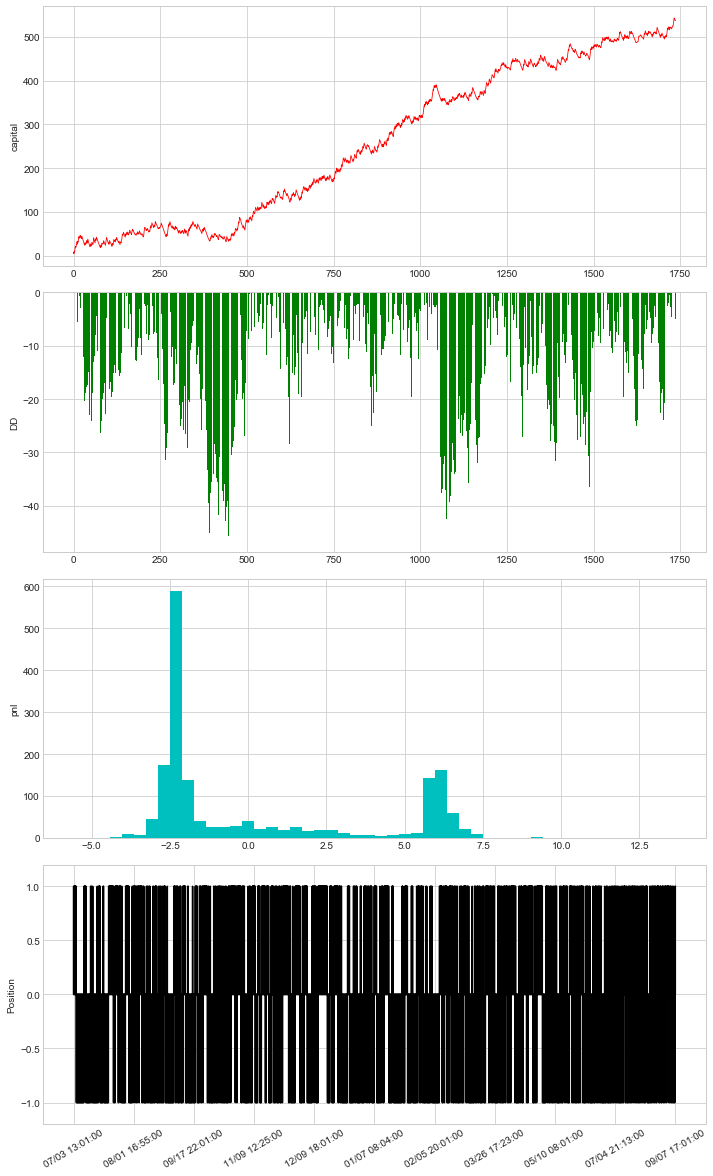

In [16]:
# 显示逐日回测结果
engine.showDailyResult()
# 显示逐笔回测结果
engine.showBacktestingResult()

In [17]:
engine.calculateBacktestingResult()

2018-09-09 19:38:39.108649	计算回测结果
单笔盈亏： 7.948435168685246 入场时间： 2017-07-03 13:01:00 开仓价： 3.3109 出场时间 2017-07-03 13:20:00 平仓价： 3.5787 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -3.773832976445391 入场时间： 2017-07-03 16:01:00 开仓价： 4.67 出场时间 2017-07-03 16:02:00 平仓价： 4.5003 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 6.138118609406962 入场时间： 2017-07-03 17:01:00 开仓价： 4.89 出场时间 2017-07-03 17:16:00 平仓价： 5.197 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.202790697674424 入场时间： 2017-07-03 19:01:00 开仓价： 4.3 出场时间 2017-07-03 19:04:00 平仓价： 4.2113 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 5.500037945209422 入场时间： 2017-07-03 20:01:00 开仓价： 3.4787 出场时间 2017-07-03 20:13:00 平仓价： 3.6749 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 7.365524244606098 入场时间： 2017-07-03 21:01:00 开仓价： 4.0277 出场时间 2017-07-03 21:10:00 平仓价： 4.33 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -0.05828132728328369 入场时间： 2017-07-04 03:01:00 开仓价： 4.6501 出场时间 2017-07-04 03:06:00 平仓价： 4.6539 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -1.8543994625395055 

单笔盈亏： 7.727185163027219 入场时间： 2017-07-14 15:01:00 开仓价： 1.6715 出场时间 2017-07-14 21:00:00 平仓价： 1.54 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.2046669263732017 入场时间： 2017-07-14 21:01:00 开仓价： 1.5402 出场时间 2017-07-14 22:46:00 平仓价： 1.572 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 1.9027890192035093 入场时间： 2017-07-15 03:01:00 开仓价： 1.5518 出场时间 2017-07-15 06:01:00 平仓价： 1.5201 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -0.8373225445694324 入场时间： 2017-07-15 06:01:00 开仓价： 1.5201 出场时间 2017-07-15 06:13:00 平仓价： 1.5095 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -0.03406779661016646 入场时间： 2017-07-15 07:01:00 开仓价： 1.5104 出场时间 2017-07-15 07:17:00 平仓价： 1.512 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 6.510229436339975 入场时间： 2017-07-15 10:01:00 开仓价： 1.4601 出场时间 2017-07-15 11:42:00 平仓价： 1.363 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.8118639262934138 入场时间： 2017-07-15 12:01:00 开仓价： 1.411 出场时间 2017-07-15 12:14:00 平仓价： 1.4487 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -1.7961964591661828 入场时间： 2017-07-15 17:

单笔盈亏： -1.247553409269861 入场时间： 2017-08-08 18:01:00 开仓价： 1.9051 出场时间 2017-08-08 19:00:00 平仓价： 1.884 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.5805977851843944 入场时间： 2017-08-09 02:01:00 开仓价： 1.8602 出场时间 2017-08-09 02:15:00 平仓价： 1.8148 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -1.4326855542389327 入场时间： 2017-08-09 04:02:00 开仓价： 1.8566 出场时间 2017-08-09 04:36:00 平仓价： 1.8326 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 0.931390115214818 入场时间： 2017-08-09 07:01:00 开仓价： 1.8574 出场时间 2017-08-09 13:01:00 平仓价： 1.8773 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 2.091928833963674 入场时间： 2017-08-09 13:01:00 开仓价： 1.8773 出场时间 2017-08-10 09:01:00 平仓价： 1.8354 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -0.8755344883948919 入场时间： 2017-08-10 09:01:00 开仓价： 1.8354 出场时间 2017-08-10 11:04:00 平仓价： 1.8219 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.4891958943959573 入场时间： 2017-08-10 11:04:00 开仓价： 1.8219 出场时间 2017-08-10 17:46:00 平仓价： 1.8647 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.26800171526587 入场时间： 2017-08-10 18:0

单笔盈亏： 6.260678525369178 入场时间： 2017-09-09 07:01:00 开仓价： 0.86069 出场时间 2017-09-09 10:35:00 平仓价： 0.8056 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -0.5058536585365858 入场时间： 2017-09-09 11:02:00 开仓价： 0.82 出场时间 2017-09-09 20:01:00 平仓价： 0.823 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.3271202916160276 入场时间： 2017-09-09 20:01:00 开仓价： 0.823 出场时间 2017-09-09 20:21:00 平仓价： 0.805 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.040280054732156 入场时间： 2017-09-09 22:01:00 开仓价： 0.78199 出场时间 2017-09-09 22:26:00 平仓价： 0.76713 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 0.4757254740313282 入场时间： 2017-09-09 23:02:00 开仓价： 0.77632 出场时间 2017-09-10 00:01:00 平仓价： 0.7811 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.4316399948790206 入场时间： 2017-09-10 00:01:00 开仓价： 0.7811 出场时间 2017-09-10 06:45:00 平仓价： 0.799 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 5.909685914919344 入场时间： 2017-09-10 07:01:00 开仓价： 0.81029 出场时间 2017-09-10 14:10:00 平仓价： 0.76127 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.144517221908525 入场时间： 2017-09-10 1

单笔盈亏： -2.6319268030139864 入场时间： 2017-10-11 17:01:00 开仓价： 0.5574 出场时间 2017-10-11 22:03:00 平仓价： 0.57129 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.0960325428423014 入场时间： 2017-10-11 23:01:00 开仓价： 0.5777 出场时间 2017-10-12 02:40:00 平仓价： 0.589 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.416692839406746 入场时间： 2017-10-12 04:01:00 开仓价： 0.59604 出场时间 2017-10-12 17:18:00 平仓价： 0.58247 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -1.5815720383345437 入场时间： 2017-10-12 20:01:00 开仓价： 0.62085 出场时间 2017-10-13 01:23:00 平仓价： 0.6119 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 5.871194937941092 入场时间： 2017-10-13 02:01:00 开仓价： 0.61635 出场时间 2017-10-13 08:11:00 平仓价： 0.5793 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 6.4857668711656355 入场时间： 2017-10-13 10:01:00 开仓价： 0.5705 出场时间 2017-10-13 14:07:00 平仓价： 0.6083 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -1.4557031301266534 入场时间： 2017-10-13 15:01:00 开仓价： 0.60956 出场时间 2017-10-13 15:30:00 平仓价： 0.60154 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -1.5097068403908842 入场时间： 2017

单笔盈亏： -1.341802704056074 入场时间： 2017-11-05 19:01:00 开仓价： 0.9985 出场时间 2017-11-05 19:25:00 平仓价： 1.0105 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.583060151839585 入场时间： 2017-11-05 20:01:00 开仓价： 1.0274 出场时间 2017-11-05 23:00:00 平仓价： 1.0525 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.149259259259243 入场时间： 2017-11-06 03:01:00 开仓价： 1.08 出场时间 2017-11-06 05:13:00 平仓价： 1.1017 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 6.54002090228185 入场时间： 2017-11-06 06:01:00 开仓价： 1.1482 出场时间 2017-11-06 08:01:00 平仓价： 1.0715 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.0240987694040036 入场时间： 2017-11-06 13:02:00 开仓价： 0.99464 出场时间 2017-11-06 14:55:00 平仓价： 0.9759 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -1.3849392712550586 入场时间： 2017-11-06 18:02:00 开仓价： 0.988 出场时间 2017-11-06 18:13:00 平仓价： 1.0003 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.5951012609858672 入场时间： 2017-11-06 19:01:00 开仓价： 1.0468 出场时间 2017-11-06 20:40:00 平仓价： 1.0725 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 5.951954022988504 入场时间： 2017-11-06 23

单笔盈亏： -2.626446826723187 入场时间： 2017-11-27 08:01:00 开仓价： 2.4533 出场时间 2017-11-27 10:34:00 平仓价： 2.3923 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.0011851105191107 入场时间： 2017-11-27 16:01:00 开仓价： 2.7778 出场时间 2017-11-27 16:40:00 平仓价： 2.7261 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.075993678387991 入场时间： 2017-11-27 17:01:00 开仓价： 2.7841 出场时间 2017-11-27 17:11:00 平仓价： 2.7302 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.389452010492659 入场时间： 2017-11-28 00:01:00 开仓价： 2.7829 出场时间 2017-11-28 01:23:00 平仓价： 2.7203 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.273233532934131 入场时间： 2017-11-28 06:01:00 开仓价： 2.9392 出场时间 2017-11-28 06:08:00 平仓价： 2.8765 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.2448951048951065 入场时间： 2017-11-28 08:01:00 开仓价： 2.86 出场时间 2017-11-28 08:19:00 平仓价： 2.7998 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 5.959167822468792 入场时间： 2017-11-28 11:01:00 开仓价： 2.884 出场时间 2017-11-28 15:28:00 平仓价： 3.0599 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.2899999999999925 入场时间： 2017-11-28 16:01:0

单笔盈亏： 6.012969037803696 入场时间： 2017-12-09 13:01:00 开仓价： 4.5604 出场时间 2017-12-09 16:34:00 平仓价： 4.2798 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.6311032028469645 入场时间： 2017-12-09 18:01:00 开仓价： 4.215 出场时间 2017-12-09 18:41:00 平仓价： 4.11 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.0039798488665057 入场时间： 2017-12-09 21:01:00 开仓价： 3.97 出场时间 2017-12-09 21:26:00 平仓价： 3.896 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.517020467397282 入场时间： 2017-12-09 23:01:00 开仓价： 3.9966 出场时间 2017-12-09 23:34:00 平仓价： 3.9016 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -3.2437270806708165 入场时间： 2017-12-10 01:01:00 开仓价： 3.8341 出场时间 2017-12-10 01:12:00 平仓价： 3.7151 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 2.36918635170604 入场时间： 2017-12-10 02:01:00 开仓价： 3.81 出场时间 2017-12-10 05:01:00 平仓价： 3.9056 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.300999590331832 入场时间： 2017-12-10 05:01:00 开仓价： 3.9056 出场时间 2017-12-10 06:19:00 平仓价： 3.99 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 6.135774162105423 入场时间： 2017-12-10 07:01:00 开仓价： 4

单笔盈亏： -1.455338135570864 入场时间： 2017-12-30 14:01:00 开仓价： 7.5798 出场时间 2017-12-30 15:31:00 平仓价： 7.6795 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 5.90551365409623 入场时间： 2017-12-30 16:01:00 开仓价： 7.69 出场时间 2017-12-30 20:23:00 平仓价： 7.2251 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 6.329396142454262 入场时间： 2017-12-30 21:01:00 开仓价： 7.0563 出场时间 2017-12-30 21:19:00 平仓价： 6.5998 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.138510796723751 入场时间： 2017-12-31 01:01:00 开仓价： 6.715 出场时间 2017-12-31 01:10:00 平仓价： 6.8492 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.441494368239096 入场时间： 2017-12-31 02:01:00 开仓价： 7.1736 出场时间 2017-12-31 03:02:00 平仓价： 7.3387 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 6.023422877065498 入场时间： 2017-12-31 04:01:00 开仓价： 7.4861 出场时间 2017-12-31 14:46:00 平仓价： 7.0247 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 5.950638060361845 入场时间： 2017-12-31 22:01:00 开仓价： 7.3457 出场时间 2018-01-01 00:34:00 平仓价： 7.7931 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.3983979328165415 入场时间： 2018-01-01 02:01:0

单笔盈亏： -2.7760486446090082 入场时间： 2018-01-12 20:01:00 开仓价： 14.719 出场时间 2018-01-12 20:05:00 平仓价： 14.331 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.1455517002081868 入场时间： 2018-01-12 21:01:00 开仓价： 14.41 出场时间 2018-01-12 21:08:00 平仓价： 14.121 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.646963788300832 入场时间： 2018-01-12 22:01:00 开仓价： 14.36 出场时间 2018-01-12 22:26:00 平仓价： 14.0 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.3927432599374954 入场时间： 2018-01-13 01:01:00 开仓价： 13.761 出场时间 2018-01-13 06:52:00 平仓价： 13.451 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 6.404011544011546 入场时间： 2018-01-13 09:01:00 开仓价： 13.86 出场时间 2018-01-13 10:09:00 平仓价： 14.767 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 6.641906504321478 入场时间： 2018-01-13 12:01:00 开仓价： 15.851 出场时间 2018-01-13 12:42:00 平仓价： 16.926 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.55763184527156 入场时间： 2018-01-13 15:01:00 开仓价： 17.786 出场时间 2018-01-13 15:10:00 平仓价： 17.356 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 6.468550733927316 入场时间： 2018-01-13 18:01:00 开仓价

单笔盈亏： -2.213365231259965 入场时间： 2018-01-22 09:01:00 开仓价： 13.794 出场时间 2018-01-22 12:15:00 平仓价： 14.08 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.616539899809491 入场时间： 2018-01-22 13:01:00 开仓价： 14.173 出场时间 2018-01-22 15:35:00 平仓价： 14.524 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.064137931034482 入场时间： 2018-01-22 16:01:00 开仓价： 14.5 出场时间 2018-01-22 17:19:00 平仓价： 14.779 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.544607631389499 入场时间： 2018-01-22 21:01:00 开仓价： 13.89 出场时间 2018-01-22 21:08:00 平仓价： 13.556 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.6624130071417773 入场时间： 2018-01-22 23:01:00 开仓价： 13.162 出场时间 2018-01-22 23:49:00 平仓价： 12.83 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 5.918972977134491 入场时间： 2018-01-23 00:01:00 开仓价： 12.989 出场时间 2018-01-23 01:39:00 平仓价： 13.776 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.1493078230036216 入场时间： 2018-01-23 07:01:00 开仓价： 13.537 出场时间 2018-01-23 08:24:00 平仓价： 13.265 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.2208293269230848 入场时间： 2018-01-23 09:01:

单笔盈亏： -2.264038575706798 入场时间： 2018-02-07 01:01:00 开仓价： 7.5799 出场时间 2018-02-07 03:23:00 平仓价： 7.7409 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.1930120481927804 入场时间： 2018-02-07 06:01:00 开仓价： 8.3 出场时间 2018-02-07 06:04:00 平仓价： 8.1296 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.4026654075863663 入场时间： 2018-02-07 09:01:00 开仓价： 8.1541 出场时间 2018-02-07 10:39:00 平仓价： 7.9696 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.3622222222222247 入场时间： 2018-02-07 14:01:00 开仓价： 7.92 出场时间 2018-02-07 14:12:00 平仓价： 7.744 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.2725122590945306 入场时间： 2018-02-07 19:01:00 开仓价： 8.769 出场时间 2018-02-07 19:16:00 平仓价： 8.582 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.4391175104505387 入场时间： 2018-02-07 20:01:00 开仓价： 8.612 出场时间 2018-02-07 22:27:00 平仓价： 8.414 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.0920467836257313 入场时间： 2018-02-07 23:01:00 开仓价： 8.55 出场时间 2018-02-07 23:34:00 平仓价： 8.3831 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.185673620449606 入场时间： 2018-02-08 00:01:00 开仓

单笔盈亏： -1.9500053418139771 入场时间： 2018-03-03 23:01:00 开仓价： 8.0497 出场时间 2018-03-04 05:01:00 平仓价： 7.904 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.2338765182186204 入场时间： 2018-03-04 05:01:00 开仓价： 7.904 出场时间 2018-03-05 07:08:00 平仓价： 8.0695 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.430048094709579 入场时间： 2018-03-05 09:01:00 开仓价： 8.109 出场时间 2018-03-06 08:00:00 平仓价： 7.9233 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 5.99894200127469 入场时间： 2018-03-06 11:01:00 开仓价： 7.845 出场时间 2018-03-07 01:30:00 平仓价： 7.3634 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 6.080680083275503 入场时间： 2018-03-07 02:01:00 开仓价： 7.205 出场时间 2018-03-07 15:31:00 平仓价： 6.7568 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.0553948581378614 入场时间： 2018-03-07 19:01:00 开仓价： 6.8341 出场时间 2018-03-07 19:36:00 平仓价： 6.965 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 5.815260836155618 入场时间： 2018-03-07 20:01:00 开仓价： 7.0274 出场时间 2018-03-08 00:29:00 平仓价： 6.6089 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.4007182407846863 入场时间： 2018-03-08 04:01:0

单笔盈亏： -2.5510529167419134 入场时间： 2018-03-27 20:01:00 开仓价： 5.537 出场时间 2018-03-27 21:09:00 平仓价： 5.6705 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 1.8555513187162296 入场时间： 2018-03-27 22:01:00 开仓价： 6.294 出场时间 2018-03-27 23:01:00 平仓价： 6.1684 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.508523442059524 入场时间： 2018-03-27 23:01:00 开仓价： 6.1684 出场时间 2018-03-28 01:20:00 平仓价： 6.0223 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.2771052674217 入场时间： 2018-03-28 06:01:00 开仓价： 6.1719 出场时间 2018-03-28 06:10:00 平仓价： 6.04 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 5.963880556173138 入场时间： 2018-03-28 10:01:00 开仓价： 5.8471 出场时间 2018-03-28 14:55:00 平仓价： 6.204 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 2.7195524043041726 入场时间： 2018-03-28 18:01:00 开仓价： 6.4031 出场时间 2018-03-28 22:01:00 平仓价： 6.22 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.307202572347257 入场时间： 2018-03-28 22:01:00 开仓价： 6.22 出场时间 2018-03-28 22:12:00 平仓价： 6.0852 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 0.8880867355358194 入场时间： 2018-03-29 00:01:00 开仓价： 

单笔盈亏： -2.7270290891750184 入场时间： 2018-05-01 11:01:00 开仓价： 16.776 出场时间 2018-05-01 12:53:00 平仓价： 17.21 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.4602267091746413 入场时间： 2018-05-01 13:01:00 开仓价： 16.938 出场时间 2018-05-01 17:02:00 平仓价： 17.331 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.335665847103896 入场时间： 2018-05-01 20:01:00 开仓价： 17.489 出场时间 2018-05-02 05:11:00 平仓价： 17.873 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.6036296060316375 入场时间： 2018-05-02 08:01:00 开仓价： 18.834 出场时间 2018-05-02 09:26:00 平仓价： 18.37 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.2238828805064608 入场时间： 2018-05-02 10:01:00 开仓价： 18.955 出场时间 2018-05-02 11:45:00 平仓价： 18.56 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.4348724775038466 入场时间： 2018-05-02 15:01:00 开仓价： 18.781 出场时间 2018-05-02 21:02:00 平仓价： 18.35 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -0.06418498862775185 入场时间： 2018-05-02 23:01:00 开仓价： 18.466 出场时间 2018-05-03 04:01:00 平仓价： 18.48 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.2070995670995557 入场时间： 2018-05-03 

单笔盈亏： -2.592583387835178 入场时间： 2018-05-28 04:01:00 开仓价： 12.232 出场时间 2018-05-28 13:45:00 平仓价： 11.932 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 0.8948956551488235 入场时间： 2018-05-28 14:01:00 开仓价： 11.692 出场时间 2018-05-28 17:01:00 平仓价： 11.813 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.2986387877761705 入场时间： 2018-05-28 17:01:00 开仓价： 11.813 出场时间 2018-05-28 20:22:00 平仓价： 12.068 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 6.507020301244265 入场时间： 2018-05-28 21:01:00 开仓价： 12.216 出场时间 2018-05-29 06:23:00 平仓价： 11.404 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 0.4873094440147839 入场时间： 2018-05-29 09:01:00 开仓价： 11.637 出场时间 2018-05-29 11:01:00 平仓价： 11.564 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.0078657903839443 入场时间： 2018-05-29 11:01:00 开仓价： 11.564 出场时间 2018-05-29 13:12:00 平仓价： 11.348 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.731911764705883 入场时间： 2018-05-29 14:01:00 开仓价： 10.88 出场时间 2018-05-29 15:24:00 平仓价： 11.162 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.63506372285048 入场时间： 2018-05-29 17:

单笔盈亏： 6.080883068721747 入场时间： 2018-06-23 09:01:00 开仓价： 8.629 出场时间 2018-06-23 14:03:00 平仓价： 8.0922 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.392777607267822 入场时间： 2018-06-23 15:01:00 开仓价： 8.1455 出场时间 2018-06-23 15:16:00 平仓价： 8.329 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.1291412850290863 入场时间： 2018-06-23 17:01:00 开仓价： 8.2146 出场时间 2018-06-23 17:44:00 平仓价： 8.378 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.2520844833793374 入场时间： 2018-06-23 18:02:00 开仓价： 8.333 出场时间 2018-06-24 06:02:00 平仓价： 8.509 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 3.094244946492274 入场时间： 2018-06-24 07:01:00 开仓价： 8.41 出场时间 2018-06-24 11:01:00 平仓价： 8.138 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.792985991644133 入场时间： 2018-06-24 11:01:00 开仓价： 8.138 出场时间 2018-06-24 11:21:00 平仓价： 7.9221 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 5.881561924796217 入场时间： 2018-06-24 12:01:00 开仓价： 7.606 出场时间 2018-06-24 14:12:00 平仓价： 7.148 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.6472724754121075 入场时间： 2018-06-24 15:01:00 开仓

单笔盈亏： 6.324705029714448 入场时间： 2018-07-24 21:01:00 开仓价： 8.2788 出场时间 2018-07-25 08:11:00 平仓价： 8.814 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.237110448564182 入场时间： 2018-07-25 10:01:00 开仓价： 8.9218 出场时间 2018-07-25 11:26:00 平仓价： 8.7347 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.303794473582634 入场时间： 2018-07-25 12:01:00 开仓价： 8.8086 出场时间 2018-07-25 16:11:00 平仓价： 8.618 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -0.5198492326811127 入场时间： 2018-07-25 18:01:00 开仓价： 8.5297 出场时间 2018-07-26 03:01:00 平仓价： 8.4973 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.2477283372365346 入场时间： 2018-07-26 03:01:00 开仓价： 8.4973 出场时间 2018-07-26 06:21:00 平仓价： 8.6764 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.386706810002444 入场时间： 2018-07-26 10:01:00 开仓价： 8.5859 出场时间 2018-07-26 14:45:00 平仓价： 8.7788 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.2437803914382894 入场时间： 2018-07-26 16:01:00 开仓价： 8.7319 出场时间 2018-07-26 20:09:00 平仓价： 8.5482 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.317313757980963 入场时间： 2018-07-26 21:0

单笔盈亏： -1.0345661939919497 入场时间： 2018-08-20 02:01:00 开仓价： 5.1198 出场时间 2018-08-20 17:01:00 平仓价： 5.074 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 5.910453291288914 入场时间： 2018-08-20 17:01:00 开仓价： 5.074 出场时间 2018-08-21 06:19:00 平仓价： 4.767 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.3521679386085435 入场时间： 2018-08-21 07:01:00 开仓价： 4.7303 出场时间 2018-08-21 15:29:00 平仓价： 4.83494218 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 0.1681632653061293 入场时间： 2018-08-21 17:01:00 开仓价： 4.9 出场时间 2018-08-22 07:01:00 平仓价： 4.8849 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 5.94814919445638 入场时间： 2018-08-22 07:01:00 开仓价： 4.8849 出场时间 2018-08-22 09:07:00 平仓价： 5.1823 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.5006305267204887 入场时间： 2018-08-22 11:01:00 开仓价： 5.202 出场时间 2018-08-22 13:20:00 平仓价： 5.0792 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.7380198019801933 入场时间： 2018-08-22 15:01:00 开仓价： 5.05 出场时间 2018-08-22 23:59:00 平仓价： 4.9188 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -0.943739503796617 入场时间： 2018-08-23 01:01:0

{'capital': 537.8498417210023,
 'maxCapital': 542.8476103153625,
 'drawdown': -4.9977685943601955,
 'totalResult': 1737,
 'totalTurnover': 347400,
 'totalCommission': 173.69999999999442,
 'totalSlippage': 69.47999999999966,
 'timeList': [Timestamp('2017-07-03 13:20:00'),
  Timestamp('2017-07-03 16:02:00'),
  Timestamp('2017-07-03 17:16:00'),
  Timestamp('2017-07-03 19:04:00'),
  Timestamp('2017-07-03 20:13:00'),
  Timestamp('2017-07-03 21:10:00'),
  Timestamp('2017-07-04 03:06:00'),
  Timestamp('2017-07-04 10:01:00'),
  Timestamp('2017-07-04 10:39:00'),
  Timestamp('2017-07-04 11:05:00'),
  Timestamp('2017-07-04 19:59:00'),
  Timestamp('2017-07-04 20:11:00'),
  Timestamp('2017-07-04 22:25:00'),
  Timestamp('2017-07-05 03:09:00'),
  Timestamp('2017-07-05 05:25:00'),
  Timestamp('2017-07-05 06:11:00'),
  Timestamp('2017-07-05 07:10:00'),
  Timestamp('2017-07-05 09:28:00'),
  Timestamp('2017-07-05 13:04:00'),
  Timestamp('2017-07-05 15:47:00'),
  Timestamp('2017-07-05 16:58:00'),
  Timest

# ETH品种

In [9]:
if __name__=="__main__":
    from vnpy.trader.app.ctaStrategy.ctaBacktesting import BacktestingEngine, OptimizationSetting, MINUTE_DB_NAME
    # 创建回测引擎对象
    engine = BacktestingEngine()
    # 设置回测使用的数据
    engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
    engine.setDatabase(MINUTE_DB_NAME)  # 设置使用的历史数据库
    engine.setStartDate('20171231',initDays=1)               # 设置回测用的数据起始日期
    engine.setEndDate('20180907')
    
    # 配置回测引擎参数
    engine.setSlippage(0.0002)     # 设置滑点为股指1跳
    engine.setRate(5/10000)   # 设置手续费万0.3
    engine.setSize(100)     # 设置期货合约大小 100美金
    # engine.setPriceTick(0.0001)    # 设置价格变动
    engine.setCapital(100000)  
    # # 在引擎中创建策略对象
    d = {'symbolList':['ETHUSDT:binance']}          # 策略参数配置 tBTCUSD:bitfinex   BTCUSDT:binance
    engine.initStrategy(MultiSignalStrategy, d)    # 创建策略对象
#     test = open('log.txt','w') 
    engine.runBacktesting()
#     test.close()

仓位字典构造完成 
初始仓位: {'ETHUSDT:binance_LONG': 0, 'ETHUSDT:binance_SHORT': 0} 
可平仓量: {'ETHUSDT:binance_LONG': 0, 'ETHUSDT:binance_SHORT': 0}
2018-09-09 18:58:33.029370	开始回测
2018-09-09 18:58:33.029370	策略初始化
2018-09-09 18:58:33.029370	载入历史数据。数据范围:[20171230,20171231)
2018-09-09 18:58:33.066298	策略初始化完成
2018-09-09 18:58:33.066298	策略启动完成
2018-09-09 18:58:33.066797	开始回放回测数据,回测范围:[20171231,20180908)
2018-09-09 18:58:33.069292	载入历史数据。数据范围:[20171231,20180908)
2018-09-09 18:59:39.230611	载入完成，数据量：356652
2018-09-09 18:59:39.232109	当前回放数据:[20171231,20180908)
trade direction 多 offset 开仓 price 852.0 2018-01-02 10:01:00
trade direction 空 offset 平仓 price 832.01 2018-01-02 10:04:00
trade direction 多 offset 开仓 price 852.38 2018-01-02 11:01:00
trade direction 空 offset 平仓 price 831.0 2018-01-02 11:13:00
trade direction 多 offset 开仓 price 826.99 2018-01-02 12:01:00
trade direction 空 offset 平仓 price 878.0 2018-01-03 00:39:00
trade direction 多 offset 开仓 price 861.64 2018-01-03 01:01:00
trade direction 空 offset 平仓 pri

trade direction 多 offset 平仓 price 1357.01 2018-01-15 08:11:00
trade direction 空 offset 开仓 price 1320.0 2018-01-15 10:01:00
trade direction 多 offset 平仓 price 1303.01 2018-01-15 17:01:00
trade direction 多 offset 开仓 price 1303.01 2018-01-15 17:01:00
trade direction 空 offset 平仓 price 1275.93 2018-01-15 19:32:00
trade direction 多 offset 开仓 price 1322.91 2018-01-15 21:01:00
trade direction 空 offset 平仓 price 1295.01 2018-01-15 21:23:00
trade direction 多 offset 开仓 price 1297.04 2018-01-15 22:01:00
trade direction 空 offset 平仓 price 1297.3 2018-01-16 02:01:00
trade direction 空 offset 开仓 price 1297.3 2018-01-16 02:01:00
trade direction 多 offset 平仓 price 1214.0 2018-01-16 08:37:00
trade direction 空 offset 开仓 price 1215.8 2018-01-16 15:01:00
trade direction 多 offset 平仓 price 1135.44 2018-01-16 15:58:00
trade direction 空 offset 开仓 price 1145.0 2018-01-16 16:01:00
trade direction 多 offset 平仓 price 1070.02 2018-01-16 16:25:00
trade direction 空 offset 开仓 price 1022.0 2018-01-16 22:01:00
trade direction

trade direction 空 offset 平仓 price 1244.02 2018-01-28 18:35:00
trade direction 多 offset 开仓 price 1266.3 2018-01-28 20:01:00
trade direction 空 offset 平仓 price 1241.0 2018-01-28 20:43:00
trade direction 多 offset 开仓 price 1225.0 2018-01-28 21:01:00
trade direction 空 offset 平仓 price 1201.99 2018-01-29 09:41:00
trade direction 多 offset 开仓 price 1209.38 2018-01-29 12:01:00
trade direction 空 offset 平仓 price 1197.23 2018-01-29 15:01:00
trade direction 空 offset 开仓 price 1197.23 2018-01-29 15:01:00
trade direction 多 offset 平仓 price 1124.99 2018-01-30 11:25:00
trade direction 空 offset 开仓 price 1161.52 2018-01-30 14:01:00
trade direction 多 offset 平仓 price 1183.13 2018-01-30 16:19:00
trade direction 空 offset 开仓 price 1164.49 2018-01-30 21:01:00
trade direction 多 offset 平仓 price 1093.0 2018-01-31 02:05:00
trade direction 空 offset 开仓 price 1070.97 2018-01-31 03:01:00
trade direction 多 offset 平仓 price 1095.1 2018-01-31 03:26:00
trade direction 空 offset 开仓 price 1090.79 2018-01-31 06:01:00
trade directi

trade direction 空 offset 平仓 price 842.05 2018-02-13 13:01:00
trade direction 空 offset 开仓 price 842.05 2018-02-13 13:01:00
trade direction 多 offset 平仓 price 854.76 2018-02-14 12:01:00
trade direction 多 offset 开仓 price 854.76 2018-02-14 12:01:00
trade direction 空 offset 平仓 price 907.78 2018-02-15 00:20:00
trade direction 多 offset 开仓 price 909.74 2018-02-15 01:01:00
trade direction 空 offset 平仓 price 924.61 2018-02-16 08:01:00
trade direction 空 offset 开仓 price 924.61 2018-02-16 08:01:00
trade direction 多 offset 平仓 price 942.91 2018-02-16 10:11:00
trade direction 多 offset 开仓 price 920.1 2018-02-16 17:01:00
trade direction 空 offset 平仓 price 916.45 2018-02-16 19:01:00
trade direction 空 offset 开仓 price 916.45 2018-02-16 19:01:00
trade direction 多 offset 平仓 price 935.0 2018-02-16 23:28:00
trade direction 多 offset 开仓 price 936.49 2018-02-17 01:01:00
trade direction 空 offset 平仓 price 932.8 2018-02-17 03:01:00
trade direction 空 offset 开仓 price 932.8 2018-02-17 03:01:00
trade direction 多 offset 平仓 

trade direction 多 offset 平仓 price 577.2 2018-03-15 10:55:00
trade direction 空 offset 开仓 price 572.99 2018-03-15 11:01:00
trade direction 多 offset 平仓 price 584.67 2018-03-15 11:24:00
trade direction 空 offset 开仓 price 579.93 2018-03-15 14:01:00
trade direction 多 offset 平仓 price 593.3 2018-03-15 15:05:00
trade direction 空 offset 开仓 price 606.38 2018-03-15 19:01:00
trade direction 多 offset 平仓 price 619.0 2018-03-15 19:54:00
trade direction 空 offset 开仓 price 617.66 2018-03-15 20:01:00
trade direction 多 offset 平仓 price 586.2 2018-03-16 10:01:00
trade direction 多 offset 开仓 price 586.2 2018-03-16 10:01:00
trade direction 空 offset 平仓 price 606.8 2018-03-16 13:01:00
trade direction 空 offset 开仓 price 606.8 2018-03-16 13:01:00
trade direction 多 offset 平仓 price 619.4 2018-03-16 23:42:00
trade direction 多 offset 开仓 price 603.01 2018-03-17 09:01:00
trade direction 空 offset 平仓 price 601.15 2018-03-17 19:01:00
trade direction 空 offset 开仓 price 601.15 2018-03-17 19:01:00
trade direction 多 offset 平仓 pric

trade direction 空 offset 平仓 price 435.4 2018-04-12 10:54:00
trade direction 多 offset 开仓 price 437.07 2018-04-12 12:01:00
trade direction 空 offset 平仓 price 427.42 2018-04-12 14:34:00
trade direction 多 offset 开仓 price 422.25 2018-04-12 16:01:00
trade direction 空 offset 平仓 price 448.86 2018-04-12 19:15:00
trade direction 多 offset 开仓 price 462.3 2018-04-12 21:01:00
trade direction 空 offset 平仓 price 452.99 2018-04-13 00:57:00
trade direction 多 offset 开仓 price 493.2 2018-04-13 07:01:00
trade direction 空 offset 平仓 price 483.02 2018-04-13 09:49:00
trade direction 多 offset 开仓 price 485.63 2018-04-13 10:01:00
trade direction 空 offset 平仓 price 515.6 2018-04-13 15:56:00
trade direction 多 offset 开仓 price 519.65 2018-04-13 17:01:00
trade direction 空 offset 平仓 price 507.0 2018-04-13 18:11:00
trade direction 多 offset 开仓 price 514.98 2018-04-13 19:01:00
trade direction 空 offset 平仓 price 504.22 2018-04-14 04:36:00
trade direction 多 offset 开仓 price 489.64 2018-04-14 06:01:00
trade direction 空 offset 平仓 p

trade direction 多 offset 开仓 price 735.72 2018-05-08 21:01:00
trade direction 空 offset 平仓 price 732.91 2018-05-09 01:01:00
trade direction 空 offset 开仓 price 732.91 2018-05-09 01:01:00
trade direction 多 offset 平仓 price 748.6 2018-05-09 02:53:00
trade direction 空 offset 开仓 price 746.49 2018-05-09 03:01:00
trade direction 多 offset 平仓 price 731.0 2018-05-09 18:01:00
trade direction 多 offset 开仓 price 731.0 2018-05-09 18:01:00
trade direction 空 offset 平仓 price 749.4 2018-05-09 23:01:00
trade direction 空 offset 开仓 price 749.4 2018-05-09 23:01:00
trade direction 多 offset 平仓 price 764.69 2018-05-10 12:57:00
trade direction 多 offset 开仓 price 759.86 2018-05-10 14:01:00
trade direction 空 offset 平仓 price 743.99 2018-05-11 01:18:00
trade direction 多 offset 开仓 price 740.27 2018-05-11 03:01:00
trade direction 空 offset 平仓 price 736.88 2018-05-11 06:01:00
trade direction 空 offset 开仓 price 736.88 2018-05-11 06:01:00
trade direction 多 offset 平仓 price 691.05 2018-05-11 15:31:00
trade direction 空 offset 开仓 p

trade direction 多 offset 平仓 price 535.36 2018-06-12 18:01:00
trade direction 多 offset 开仓 price 535.36 2018-06-12 18:01:00
trade direction 空 offset 平仓 price 523.39 2018-06-12 20:52:00
trade direction 多 offset 开仓 price 520.02 2018-06-12 21:01:00
trade direction 空 offset 平仓 price 509.41 2018-06-13 02:11:00
trade direction 空 offset 开仓 price 489.23 2018-06-13 07:01:00
trade direction 多 offset 平仓 price 499.59 2018-06-13 10:17:00
trade direction 空 offset 开仓 price 499.89 2018-06-13 11:01:00
trade direction 多 offset 平仓 price 469.08 2018-06-13 17:35:00
trade direction 空 offset 开仓 price 478.0 2018-06-13 21:01:00
trade direction 多 offset 平仓 price 488.49 2018-06-14 10:38:00
trade direction 空 offset 开仓 price 487.78 2018-06-14 11:01:00
trade direction 多 offset 平仓 price 499.0 2018-06-15 00:51:00
trade direction 多 offset 开仓 price 504.21 2018-06-15 01:01:00
trade direction 空 offset 平仓 price 493.88 2018-06-15 17:15:00
trade direction 多 offset 开仓 price 499.77 2018-06-15 19:01:00
trade direction 空 offset 平

trade direction 空 offset 平仓 price 444.6 2018-07-15 19:01:00
trade direction 空 offset 开仓 price 444.6 2018-07-15 19:01:00
trade direction 多 offset 平仓 price 446.55 2018-07-15 22:01:00
trade direction 多 offset 开仓 price 446.55 2018-07-15 22:01:00
trade direction 空 offset 平仓 price 473.32 2018-07-16 19:31:00
trade direction 多 offset 开仓 price 473.79 2018-07-16 20:01:00
trade direction 空 offset 平仓 price 468.76 2018-07-17 23:01:00
trade direction 空 offset 开仓 price 468.76 2018-07-17 23:01:00
trade direction 多 offset 平仓 price 480.09 2018-07-18 01:39:00
trade direction 空 offset 开仓 price 497.62 2018-07-18 02:01:00
trade direction 多 offset 平仓 price 509.07 2018-07-18 02:05:00
trade direction 空 offset 开仓 price 500.3 2018-07-18 05:01:00
trade direction 多 offset 平仓 price 510.92 2018-07-18 11:04:00
trade direction 多 offset 开仓 price 505.51 2018-07-18 12:01:00
trade direction 空 offset 平仓 price 495.42 2018-07-18 16:30:00
trade direction 多 offset 开仓 price 498.78 2018-07-18 17:01:00
trade direction 空 offset 平仓

trade direction 多 offset 平仓 price 295.61 2018-08-19 05:40:00
trade direction 空 offset 开仓 price 294.35 2018-08-19 06:01:00
trade direction 多 offset 平仓 price 301.03 2018-08-19 19:48:00
trade direction 多 offset 开仓 price 301.31 2018-08-19 21:01:00
trade direction 空 offset 平仓 price 294.78 2018-08-20 00:27:00
trade direction 多 offset 开仓 price 296.98 2018-08-20 01:01:00
trade direction 空 offset 平仓 price 296.12 2018-08-20 15:01:00
trade direction 空 offset 开仓 price 296.12 2018-08-20 15:01:00
trade direction 多 offset 平仓 price 278.15 2018-08-21 06:12:00
trade direction 空 offset 开仓 price 271.56 2018-08-21 07:01:00
trade direction 多 offset 平仓 price 277.0 2018-08-21 14:08:00
trade direction 空 offset 开仓 price 278.68 2018-08-21 15:01:00
trade direction 多 offset 平仓 price 284.81 2018-08-21 16:11:00
trade direction 空 offset 开仓 price 285.7 2018-08-21 17:01:00
trade direction 多 offset 平仓 price 276.58 2018-08-22 03:01:00
trade direction 多 offset 开仓 price 276.58 2018-08-22 03:01:00
trade direction 空 offset 平

2018-09-09 18:59:48.902297	计算按日统计结果
2018-09-09 18:59:48.951704	------------------------------
2018-09-09 18:59:48.952202	首个交易日：	2018-01-01
2018-09-09 18:59:48.952202	最后交易日：	2018-09-07
2018-09-09 18:59:48.952202	总交易日：	250
2018-09-09 18:59:48.952202	盈利交易日	130
2018-09-09 18:59:48.952202	亏损交易日：	119
2018-09-09 18:59:48.952202	起始资金：	100000
2018-09-09 18:59:48.952705	结束资金：	260,185.7
2018-09-09 18:59:48.952705	总收益率：	160.19%
2018-09-09 18:59:48.952705	年化收益：	153.78%
2018-09-09 18:59:48.952705	总盈亏：	160,185.7
2018-09-09 18:59:48.952705	最大回撤: 	-19,133.91
2018-09-09 18:59:48.952705	百分比最大回撤: -10.27%
2018-09-09 18:59:48.952705	总手续费：	45,753.6
2018-09-09 18:59:48.953200	总滑点：	26.7
2018-09-09 18:59:48.953200	总成交金额：	91,507,191.0
2018-09-09 18:59:48.953200	总成交笔数：	1,335
2018-09-09 18:59:48.953200	日均盈亏：	640.74
2018-09-09 18:59:48.953200	日均手续费：	183.01
2018-09-09 18:59:48.953200	日均滑点：	0.11
2018-09-09 18:59:48.953700	日均成交金额：	366,028.76
2018-09-09 18:59:48.953700	日均成交笔数：	5.34
2018-09-09 18:59:48.953700	日均收益率：	0.3

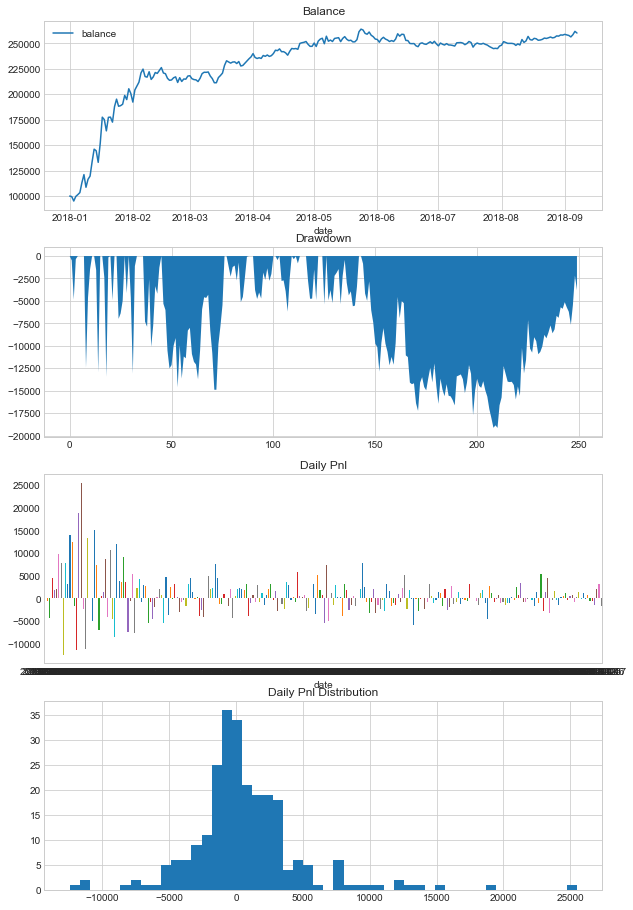

2018-09-09 18:59:52.418610	计算回测结果
单笔盈亏： -2.4862441314554005 入场时间： 2018-01-02 10:01:00 开仓价： 852.0 出场时间 2018-01-02 10:04:00 平仓价： 832.01 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.6482709589619646 入场时间： 2018-01-02 11:01:00 开仓价： 852.38 出场时间 2018-01-02 11:13:00 平仓价： 831.0 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 6.028151972817083 入场时间： 2018-01-02 12:01:00 开仓价： 826.99 出场时间 2018-01-03 00:39:00 平仓价： 878.0 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.3033164662736163 入场时间： 2018-01-03 01:01:00 开仓价： 861.64 出场时间 2018-01-03 02:47:00 平仓价： 843.0 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.350888360149825 入场时间： 2018-01-03 04:01:00 开仓价： 848.98 出场时间 2018-01-03 18:08:00 平仓价： 830.21 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -1.9551738818575095 入场时间： 2018-01-03 20:01:00 开仓价： 864.38 出场时间 2018-01-03 20:59:00 平仓价： 848.69 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.1061357408761903 入场时间： 2018-01-04 04:01:00 开仓价： 916.01 出场时间 2018-01-04 17:08:00 平仓价： 898.0 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 6.1735856

单笔盈亏： -2.078630066783046 入场时间： 2018-01-15 00:01:00 开仓价： 1248.82 出场时间 2018-01-15 00:28:00 平仓价： 1273.03 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.5328984947896567 入场时间： 2018-01-15 02:01:00 开仓价： 1295.5 出场时间 2018-01-15 06:51:00 平仓价： 1326.5 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.023746771577866 入场时间： 2018-01-15 07:01:00 开仓价： 1331.92 出场时间 2018-01-15 08:11:00 平仓价： 1357.01 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 1.1471212121212127 入场时间： 2018-01-15 10:01:00 开仓价： 1320.0 出场时间 2018-01-15 17:01:00 平仓价： 1303.01 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.2182649404072055 入场时间： 2018-01-15 17:01:00 开仓价： 1303.01 出场时间 2018-01-15 19:32:00 平仓价： 1275.93 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.2489870059187766 入场时间： 2018-01-15 21:01:00 开仓价： 1322.91 出场时间 2018-01-15 21:23:00 平仓价： 1295.01 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -0.11995435761426088 入场时间： 2018-01-15 22:01:00 开仓价： 1297.04 出场时间 2018-01-16 02:01:00 平仓价： 1297.3 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 6.281028289524395 入场时间：

单笔盈亏： 6.051441649003157 入场时间： 2018-02-06 10:01:00 开仓价： 651.06 出场时间 2018-02-06 12:19:00 平仓价： 610.75 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.20513781772988 入场时间： 2018-02-06 17:01:00 开仓价： 587.37 出场时间 2018-02-06 17:07:00 平仓价： 599.5 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.2138224708247085 入场时间： 2018-02-06 18:01:00 开仓价： 641.81 出场时间 2018-02-06 18:06:00 平仓价： 655.12 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.7754850934815654 入场时间： 2018-02-06 20:01:00 开仓价： 633.28 出场时间 2018-02-06 20:32:00 平仓价： 649.97 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.1429895366218203 入场时间： 2018-02-06 21:01:00 开仓价： 669.0 出场时间 2018-02-06 21:09:00 平仓价： 682.4 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 5.905329670329669 入场时间： 2018-02-06 22:01:00 开仓价： 728.0 出场时间 2018-02-06 22:34:00 平仓价： 683.99 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.2465535656413267 入场时间： 2018-02-07 02:01:00 开仓价： 709.69 出场时间 2018-02-07 02:43:00 平仓价： 724.64 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.318948390407639 入场时间： 2018-02-07 03

单笔盈亏： 2.0771325586197946 入场时间： 2018-03-20 02:01:00 开仓价： 532.67 出场时间 2018-03-20 10:01:00 平仓价： 544.48 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.2557801939465145 入场时间： 2018-03-20 10:01:00 开仓价： 544.48 出场时间 2018-03-20 11:23:00 平仓价： 556.0 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.5314738757473347 入场时间： 2018-03-20 14:01:00 开仓价： 538.58 出场时间 2018-03-20 15:57:00 平仓价： 525.7 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -0.9555867693701953 入场时间： 2018-03-20 19:01:00 开仓价： 529.68 出场时间 2018-03-20 23:01:00 平仓价： 534.0 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 0.05662921348313752 入场时间： 2018-03-20 23:01:00 开仓价： 534.0 出场时间 2018-03-21 00:01:00 平仓价： 535.05 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.306152696009725 入场时间： 2018-03-21 00:01:00 开仓价： 535.05 出场时间 2018-03-21 00:19:00 平仓价： 546.64 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.236329609749011 入场时间： 2018-03-21 01:01:00 开仓价： 551.44 出场时间 2018-03-21 04:06:00 平仓价： 563.0 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -0.523773896201712 入场时间： 2018-03-21 05:

单笔盈亏： 5.851773428698684 入场时间： 2018-05-04 03:01:00 开仓价： 763.38 出场时间 2018-05-04 17:05:00 平仓价： 809.12 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.481675083230461 入场时间： 2018-05-04 18:01:00 开仓价： 801.99 出场时间 2018-05-04 23:19:00 平仓价： 783.21 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 3.195050218902907 入场时间： 2018-05-05 02:01:00 开仓价： 776.6 出场时间 2018-05-05 11:01:00 平仓价： 802.5 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.3044859813084115 入场时间： 2018-05-05 11:01:00 开仓价： 802.5 出场时间 2018-05-05 18:34:00 平仓价： 819.87 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.14980452083767 入场时间： 2018-05-05 20:01:00 开仓价： 817.99 出场时间 2018-05-06 05:17:00 平仓价： 801.55 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.7765556537970366 入场时间： 2018-05-06 07:01:00 开仓价： 814.32 出场时间 2018-05-06 14:05:00 平仓价： 792.85 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.1412806187146174 入场时间： 2018-05-06 15:01:00 开仓价： 796.49 出场时间 2018-05-06 16:50:00 平仓价： 780.55 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.150778904144755 入场时间： 2018-05-06 17:01:00

单笔盈亏： 6.233074860163969 入场时间： 2018-06-22 03:01:00 开仓价： 522.04 出场时间 2018-06-22 17:59:00 平仓价： 488.77 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 0.7729272165120759 入场时间： 2018-06-22 21:01:00 开仓价： 478.68 出场时间 2018-06-24 08:01:00 平仓价： 474.31 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.220917543378804 入场时间： 2018-06-24 08:01:00 开仓价： 474.31 出场时间 2018-06-24 09:27:00 平仓价： 464.44 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.146917460181899 入场时间： 2018-06-24 11:01:00 开仓价： 468.38 出场时间 2018-06-24 12:07:00 平仓价： 458.98 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.5049034616702897 入场时间： 2018-06-24 17:01:00 开仓价： 437.65 出场时间 2018-06-25 00:43:00 平仓价： 448.0 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 1.4664257028112477 入场时间： 2018-06-25 05:01:00 开仓价： 458.16 出场时间 2018-06-25 12:01:00 平仓价： 450.8 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 3.3937178349600727 入场时间： 2018-06-25 12:01:00 开仓价： 450.8 出场时间 2018-06-25 23:01:00 平仓价： 466.73 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 3.613776273220071 入场时间： 2018-06-25 23:01:

单笔盈亏： 5.881981108887243 入场时间： 2018-08-17 06:01:00 开仓价： 284.79 出场时间 2018-08-17 15:13:00 平仓价： 301.94 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.263468331608298 入场时间： 2018-08-17 17:01:00 开仓价： 299.51 出场时间 2018-08-17 22:24:00 平仓价： 293.15 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 6.045357251856628 入场时间： 2018-08-17 23:01:00 开仓价： 294.89 出场时间 2018-08-18 06:11:00 平仓价： 313.13 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.3227411167512675 入场时间： 2018-08-18 07:01:00 开仓价： 315.2 出场时间 2018-08-18 11:02:00 平仓价： 308.32 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.6286061838093158 入场时间： 2018-08-18 15:01:00 开仓价： 304.99 出场时间 2018-08-18 22:57:00 平仓价： 297.4 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.3326229508196774 入场时间： 2018-08-18 23:01:00 开仓价： 292.8 出场时间 2018-08-18 23:27:00 平仓价： 286.38 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.3317239948836836 入场时间： 2018-08-19 03:01:00 开仓价： 289.27 出场时间 2018-08-19 05:40:00 平仓价： 295.61 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.4094071683369966 入场时间： 2018-08-19 06:01

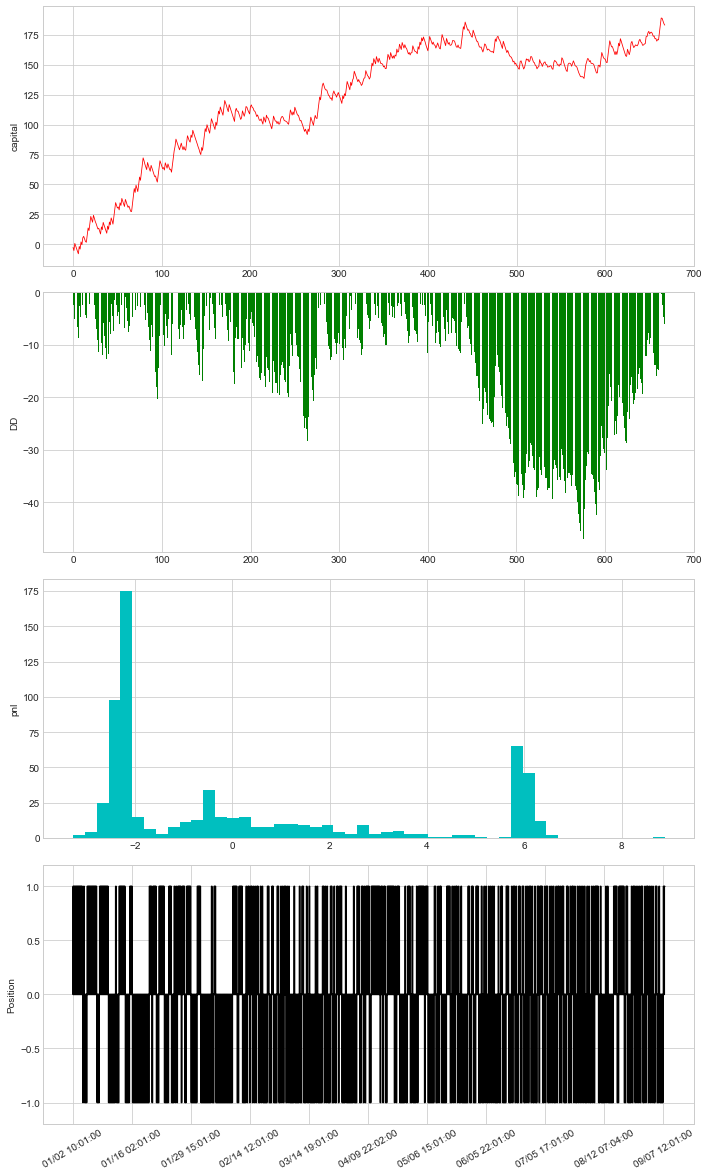

In [10]:
# 显示逐日回测结果
engine.showDailyResult()
# 显示逐笔回测结果
engine.showBacktestingResult()

In [11]:
engine.calculateBacktestingResult()

2018-09-09 18:59:57.865754	计算回测结果
单笔盈亏： -2.4862441314554005 入场时间： 2018-01-02 10:01:00 开仓价： 852.0 出场时间 2018-01-02 10:04:00 平仓价： 832.01 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.6482709589619646 入场时间： 2018-01-02 11:01:00 开仓价： 852.38 出场时间 2018-01-02 11:13:00 平仓价： 831.0 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 6.028151972817083 入场时间： 2018-01-02 12:01:00 开仓价： 826.99 出场时间 2018-01-03 00:39:00 平仓价： 878.0 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.3033164662736163 入场时间： 2018-01-03 01:01:00 开仓价： 861.64 出场时间 2018-01-03 02:47:00 平仓价： 843.0 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.350888360149825 入场时间： 2018-01-03 04:01:00 开仓价： 848.98 出场时间 2018-01-03 18:08:00 平仓价： 830.21 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -1.9551738818575095 入场时间： 2018-01-03 20:01:00 开仓价： 864.38 出场时间 2018-01-03 20:59:00 平仓价： 848.69 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.1061357408761903 入场时间： 2018-01-04 04:01:00 开仓价： 916.01 出场时间 2018-01-04 17:08:00 平仓价： 898.0 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 6.1735856

单笔盈亏： 5.996215948591529 入场时间： 2018-01-23 17:01:00 开仓价： 969.49 出场时间 2018-01-23 19:47:00 平仓价： 910.0 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 5.870600630887748 入场时间： 2018-01-23 21:01:00 开仓价： 932.02 出场时间 2018-01-24 00:01:00 平仓价： 988.04 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 3.8001197604790438 入场时间： 2018-01-24 03:01:00 开仓价： 1002.0 出场时间 2018-01-24 09:01:00 平仓价： 962.52 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 6.039611852221255 入场时间： 2018-01-24 09:01:00 开仓价： 962.52 出场时间 2018-01-24 19:35:00 平仓价： 1022.0 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.295410197809126 入场时间： 2018-01-24 20:01:00 开仓价： 1015.12 出场时间 2018-01-24 22:06:00 平仓价： 1037.0 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.2999853560314767 入场时间： 2018-01-25 11:01:00 开仓价： 1092.6 出场时间 2018-01-25 16:12:00 平仓价： 1069.0 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.296849995820061 入场时间： 2018-01-25 18:01:00 开仓价： 1076.57 出场时间 2018-01-25 20:05:00 平仓价： 1053.35 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.0289943074003873 入场时间： 2018-01-25 22

单笔盈亏： -2.3637054731960947 入场时间： 2018-02-23 18:01:00 开仓价： 853.98 出场时间 2018-02-24 04:03:00 平仓价： 834.99 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 4.554344163658242 入场时间： 2018-02-24 06:01:00 开仓价： 831.0 出场时间 2018-02-24 14:01:00 平仓价： 870.01 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 6.067974620981367 入场时间： 2018-02-24 14:01:00 开仓价： 870.01 出场时间 2018-02-25 03:01:00 平仓价： 816.0 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.087045252017228 入场时间： 2018-02-25 04:01:00 开仓价： 819.19 出场时间 2018-02-25 07:39:00 平仓价： 835.14 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.1375932611311703 入场时间： 2018-02-25 08:01:00 开仓价： 831.0 出场时间 2018-02-25 14:47:00 平仓价： 847.6 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 0.06714532315861008 入场时间： 2018-02-25 16:01:00 开仓价： 839.99 出场时间 2018-02-25 19:01:00 平仓价： 838.25 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.071404712198038 入场时间： 2018-02-25 19:01:00 开仓价： 838.25 出场时间 2018-02-25 21:36:00 平仓价： 822.06 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 1.704252343256769 入场时间： 2018-02-25 22:01:

单笔盈亏： 1.5209721425543117 入场时间： 2018-04-10 13:01:00 开仓价： 400.97 出场时间 2018-04-10 19:01:00 平仓价： 394.31 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 5.875571504653691 入场时间： 2018-04-10 19:01:00 开仓价： 394.31 出场时间 2018-04-11 06:34:00 平仓价： 418.03 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 5.84831548198636 入场时间： 2018-04-11 07:01:00 开仓价： 410.8 出场时间 2018-04-12 10:54:00 平仓价： 435.4 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.3478843205893742 入场时间： 2018-04-12 12:01:00 开仓价： 437.07 出场时间 2018-04-12 14:34:00 平仓价： 427.42 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 6.161953818827712 入场时间： 2018-04-12 16:01:00 开仓价： 422.25 出场时间 2018-04-12 19:15:00 平仓价： 448.86 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.153843824356479 入场时间： 2018-04-12 21:01:00 开仓价： 462.3 出场时间 2018-04-13 00:57:00 平仓价： 452.99 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.2040713706407153 入场时间： 2018-04-13 07:01:00 开仓价： 493.2 出场时间 2018-04-13 09:49:00 平仓价： 483.02 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 6.031365030990678 入场时间： 2018-04-13 10:01:00 开仓价

单笔盈亏： 0.4507783461650993 入场时间： 2018-05-26 03:01:00 开仓价： 580.59 出场时间 2018-05-26 05:01:00 平仓价： 584.02 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.5628622307455187 入场时间： 2018-05-26 05:01:00 开仓价： 584.02 出场时间 2018-05-26 15:25:00 平仓价： 598.17 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -0.8595205422280194 入场时间： 2018-05-26 16:01:00 开仓价： 599.01 出场时间 2018-05-26 22:01:00 平仓价： 603.32 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.167116621361801 入场时间： 2018-05-26 22:01:00 开仓价： 603.32 出场时间 2018-05-27 06:40:00 平仓价： 591.09 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -0.6758854951376515 入场时间： 2018-05-27 07:01:00 开仓价： 584.08 出场时间 2018-05-27 12:01:00 平仓价： 580.95 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 5.876008262328952 入场时间： 2018-05-27 12:01:00 开仓价： 580.95 出场时间 2018-05-28 13:38:00 平仓价： 546.0 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.2006700476989622 入场时间： 2018-05-28 17:01:00 开仓价： 530.41 出场时间 2018-05-28 20:59:00 平仓价： 541.34 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.379985128729427 入场时间： 2018-05-28 

单笔盈亏： -0.8858198003127573 入场时间： 2018-07-18 17:01:00 开仓价： 498.78 出场时间 2018-07-19 02:01:00 平仓价： 495.06 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 5.934011230961903 入场时间： 2018-07-19 02:01:00 开仓价： 495.06 出场时间 2018-07-20 00:18:00 平仓价： 464.99 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 1.0149957301451682 入场时间： 2018-07-20 03:01:00 开仓价： 468.4 出场时间 2018-07-22 01:01:00 平仓价： 462.99 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -0.008247694334647913 入场时间： 2018-07-22 01:01:00 开仓价： 462.99 出场时间 2018-07-22 20:01:00 平仓价： 463.6 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -0.5174805867126834 入场时间： 2018-07-22 20:01:00 开仓价： 463.6 出场时间 2018-07-23 05:01:00 平仓价： 465.35 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -1.9988159449876512 入场时间： 2018-07-23 05:01:00 开仓价： 465.35 出场时间 2018-07-23 05:26:00 平仓价： 456.7 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 2.0337705634325887 入场时间： 2018-07-23 07:01:00 开仓价： 457.73 出场时间 2018-07-23 15:01:00 平仓价： 467.68 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 2.4557919945261686 入场时间： 2018-07-23 15

{'capital': 182.91246088735778,
 'maxCapital': 188.84852166544366,
 'drawdown': -5.936060778085874,
 'totalResult': 668,
 'totalTurnover': 133600,
 'totalCommission': 66.80000000000048,
 'totalSlippage': 26.719999999999608,
 'timeList': [Timestamp('2018-01-02 10:04:00'),
  Timestamp('2018-01-02 11:13:00'),
  Timestamp('2018-01-03 00:39:00'),
  Timestamp('2018-01-03 02:47:00'),
  Timestamp('2018-01-03 18:08:00'),
  Timestamp('2018-01-03 20:59:00'),
  Timestamp('2018-01-04 17:08:00'),
  Timestamp('2018-01-04 21:43:00'),
  Timestamp('2018-01-05 03:07:00'),
  Timestamp('2018-01-05 12:17:00'),
  Timestamp('2018-01-05 17:17:00'),
  Timestamp('2018-01-06 01:46:00'),
  Timestamp('2018-01-06 08:01:00'),
  Timestamp('2018-01-06 10:53:00'),
  Timestamp('2018-01-06 15:43:00'),
  Timestamp('2018-01-06 19:01:00'),
  Timestamp('2018-01-07 12:01:00'),
  Timestamp('2018-01-08 01:07:00'),
  Timestamp('2018-01-08 02:33:00'),
  Timestamp('2018-01-08 08:30:00'),
  Timestamp('2018-01-08 12:57:00'),
  Timest

# BTC品种

In [12]:
if __name__=="__main__":
    from vnpy.trader.app.ctaStrategy.ctaBacktesting import BacktestingEngine, OptimizationSetting, MINUTE_DB_NAME
    # 创建回测引擎对象
    engine = BacktestingEngine()
    # 设置回测使用的数据
    engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
    engine.setDatabase(MINUTE_DB_NAME)  # 设置使用的历史数据库
    engine.setStartDate('20171231',initDays=1)               # 设置回测用的数据起始日期
    engine.setEndDate('20180907')
    
    # 配置回测引擎参数
    engine.setSlippage(0.0002)     # 设置滑点为股指1跳
    engine.setRate(5/10000)   # 设置手续费万0.3
    engine.setSize(100)     # 设置期货合约大小 100美金
    # engine.setPriceTick(0.0001)    # 设置价格变动
    engine.setCapital(100000)  
    # # 在引擎中创建策略对象
    d = {'symbolList':['BTCUSDT:binance']}          # 策略参数配置 tBTCUSD:bitfinex   BTCUSDT:binance
    engine.initStrategy(MultiSignalStrategy, d)    # 创建策略对象
#     test = open('log.txt','w') 
    engine.runBacktesting()
#     test.close()

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0} 
可平仓量: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
2018-09-09 19:01:02.654977	开始回测
2018-09-09 19:01:02.654977	策略初始化
2018-09-09 19:01:02.654977	载入历史数据。数据范围:[20171230,20171231)
2018-09-09 19:01:02.676934	策略初始化完成
2018-09-09 19:01:02.676934	策略启动完成
2018-09-09 19:01:02.676934	开始回放回测数据,回测范围:[20171231,20180908)
2018-09-09 19:01:02.678931	载入历史数据。数据范围:[20171231,20180908)
2018-09-09 19:02:09.012793	载入完成，数据量：356652
2018-09-09 19:02:09.014290	当前回放数据:[20171231,20180908)
trade direction 空 offset 开仓 price 13425.71 2018-01-02 07:01:00
trade direction 多 offset 平仓 price 13700.0 2018-01-02 08:30:00
trade direction 空 offset 开仓 price 13742.53 2018-01-02 09:01:00
trade direction 多 offset 平仓 price 12915.42 2018-01-02 12:34:00
trade direction 空 offset 开仓 price 13256.06 2018-01-02 15:01:00
trade direction 多 offset 平仓 price 13339.96 2018-01-02 16:01:00
trade direction 多 offset 开仓 price 13339.96 2018-01-02 16:01:00
trade direction

trade direction 多 offset 平仓 price 11176.82 2018-01-17 03:04:00
trade direction 空 offset 开仓 price 10594.53 2018-01-17 05:01:00
trade direction 多 offset 平仓 price 10885.88 2018-01-17 05:07:00
trade direction 空 offset 开仓 price 10100.08 2018-01-17 06:01:00
trade direction 多 offset 平仓 price 9410.0 2018-01-17 06:19:00
trade direction 空 offset 开仓 price 10770.68 2018-01-17 10:01:00
trade direction 多 offset 平仓 price 10123.45 2018-01-17 11:10:00
trade direction 空 offset 开仓 price 10814.99 2018-01-17 15:01:00
trade direction 多 offset 平仓 price 10101.01 2018-01-17 17:48:00
trade direction 空 offset 开仓 price 9987.62 2018-01-17 21:01:00
trade direction 多 offset 平仓 price 9330.0 2018-01-17 22:30:00
trade direction 空 offset 开仓 price 9288.2 2018-01-17 23:01:00
trade direction 多 offset 平仓 price 9511.0 2018-01-17 23:42:00
trade direction 空 offset 开仓 price 9719.99 2018-01-18 03:01:00
trade direction 多 offset 平仓 price 9950.14 2018-01-18 03:08:00
trade direction 空 offset 开仓 price 10290.0 2018-01-18 04:01:00
trad

trade direction 空 offset 开仓 price 9222.85 2018-02-02 08:01:00
trade direction 多 offset 平仓 price 8660.0 2018-02-02 14:15:00
trade direction 空 offset 开仓 price 8740.0 2018-02-02 15:01:00
trade direction 多 offset 平仓 price 8215.0 2018-02-02 20:13:00
trade direction 空 offset 开仓 price 8731.23 2018-02-03 02:01:00
trade direction 多 offset 平仓 price 8890.76 2018-02-03 07:04:00
trade direction 空 offset 开仓 price 8906.26 2018-02-03 08:01:00
trade direction 多 offset 平仓 price 8335.97 2018-02-03 11:11:00
trade direction 多 offset 开仓 price 8479.94 2018-02-03 13:01:00
trade direction 空 offset 平仓 price 8994.21 2018-02-03 17:01:00
trade direction 空 offset 开仓 price 8797.21 2018-02-03 19:01:00
trade direction 多 offset 平仓 price 8979.98 2018-02-03 19:21:00
trade direction 空 offset 开仓 price 9117.24 2018-02-03 20:01:00
trade direction 多 offset 平仓 price 9332.99 2018-02-03 22:13:00
trade direction 多 offset 开仓 price 9206.11 2018-02-04 00:01:00
trade direction 空 offset 平仓 price 8974.0 2018-02-04 09:52:00
trade direct

trade direction 多 offset 平仓 price 8369.99 2018-03-16 21:25:00
trade direction 空 offset 开仓 price 8481.72 2018-03-17 02:01:00
trade direction 多 offset 平仓 price 8293.1 2018-03-17 09:01:00
trade direction 多 offset 开仓 price 8293.1 2018-03-17 09:01:00
trade direction 空 offset 平仓 price 8107.54 2018-03-17 09:27:00
trade direction 多 offset 开仓 price 8229.51 2018-03-17 11:01:00
trade direction 空 offset 平仓 price 8300.7 2018-03-17 17:01:00
trade direction 空 offset 开仓 price 8300.7 2018-03-17 17:01:00
trade direction 多 offset 平仓 price 7785.01 2018-03-18 02:55:00
trade direction 空 offset 开仓 price 7797.37 2018-03-18 03:01:00
trade direction 多 offset 平仓 price 7957.01 2018-03-18 05:18:00
trade direction 空 offset 开仓 price 7934.0 2018-03-18 06:01:00
trade direction 多 offset 平仓 price 7444.0 2018-03-18 22:08:00
trade direction 空 offset 开仓 price 7380.01 2018-03-19 01:01:00
trade direction 多 offset 平仓 price 7567.11 2018-03-19 02:14:00
trade direction 空 offset 开仓 price 7661.99 2018-03-19 05:01:00
trade directio

trade direction 空 offset 平仓 price 8502.0 2018-04-20 18:42:00
trade direction 多 offset 开仓 price 8512.64 2018-04-20 21:01:00
trade direction 空 offset 平仓 price 9035.0 2018-04-21 15:30:00
trade direction 多 offset 开仓 price 8849.96 2018-04-21 16:01:00
trade direction 空 offset 平仓 price 8670.68 2018-04-21 17:46:00
trade direction 多 offset 开仓 price 8710.0 2018-04-21 18:01:00
trade direction 空 offset 平仓 price 8789.88 2018-04-22 04:01:00
trade direction 空 offset 开仓 price 8789.88 2018-04-22 04:01:00
trade direction 多 offset 平仓 price 8966.0 2018-04-22 17:04:00
trade direction 多 offset 开仓 price 8904.99 2018-04-22 18:01:00
trade direction 空 offset 平仓 price 8866.76 2018-04-23 12:01:00
trade direction 空 offset 开仓 price 8866.76 2018-04-23 12:01:00
trade direction 多 offset 平仓 price 8917.92 2018-04-24 05:01:00
trade direction 多 offset 开仓 price 8917.92 2018-04-24 05:01:00
trade direction 空 offset 平仓 price 9457.0 2018-04-25 04:01:00
trade direction 多 offset 开仓 price 9464.71 2018-04-25 05:01:00
trade directi

trade direction 多 offset 平仓 price 7616.83 2018-06-06 11:01:00
trade direction 多 offset 开仓 price 7616.83 2018-06-06 11:01:00
trade direction 空 offset 平仓 price 7650.02 2018-06-07 00:01:00
trade direction 空 offset 开仓 price 7650.02 2018-06-07 00:01:00
trade direction 多 offset 平仓 price 7703.6 2018-06-07 13:01:00
trade direction 多 offset 开仓 price 7703.6 2018-06-07 13:01:00
trade direction 空 offset 平仓 price 7669.64 2018-06-08 05:01:00
trade direction 空 offset 开仓 price 7669.64 2018-06-08 05:01:00
trade direction 多 offset 平仓 price 7662.0 2018-06-09 12:01:00
trade direction 多 offset 开仓 price 7662.0 2018-06-09 12:01:00
trade direction 空 offset 平仓 price 7605.35 2018-06-10 00:01:00
trade direction 空 offset 开仓 price 7605.35 2018-06-10 00:01:00
trade direction 多 offset 平仓 price 7140.53 2018-06-11 01:06:00
trade direction 空 offset 开仓 price 6719.99 2018-06-11 02:01:00
trade direction 多 offset 平仓 price 6692.98 2018-06-12 00:01:00
trade direction 多 offset 开仓 price 6692.98 2018-06-12 00:01:00
trade direct

trade direction 空 offset 平仓 price 7496.34 2018-07-21 01:01:00
trade direction 空 offset 开仓 price 7496.34 2018-07-21 01:01:00
trade direction 多 offset 平仓 price 7316.51 2018-07-21 02:01:00
trade direction 多 offset 开仓 price 7316.51 2018-07-21 02:01:00
trade direction 空 offset 平仓 price 7357.01 2018-07-21 04:01:00
trade direction 空 offset 开仓 price 7357.01 2018-07-21 04:01:00
trade direction 多 offset 平仓 price 7485.99 2018-07-22 10:01:00
trade direction 多 offset 开仓 price 7485.99 2018-07-22 10:01:00
trade direction 空 offset 平仓 price 7940.08 2018-07-24 13:12:00
trade direction 多 offset 开仓 price 7972.19 2018-07-24 14:01:00
trade direction 空 offset 平仓 price 8473.07 2018-07-25 07:48:00
trade direction 多 offset 开仓 price 8415.78 2018-07-25 09:01:00
trade direction 空 offset 平仓 price 8245.04 2018-07-25 17:06:00
trade direction 多 offset 开仓 price 8217.46 2018-07-25 18:01:00
trade direction 空 offset 平仓 price 8079.92 2018-07-26 03:01:00
trade direction 空 offset 开仓 price 8079.92 2018-07-26 03:01:00
trade di

trade direction 空 offset 平仓 price 6711.53 2018-08-26 04:01:00
trade direction 空 offset 开仓 price 6711.53 2018-08-26 04:01:00
trade direction 多 offset 平仓 price 6754.87 2018-08-26 09:01:00
trade direction 多 offset 开仓 price 6754.87 2018-08-26 09:01:00
trade direction 空 offset 平仓 price 6620.41 2018-08-26 11:05:00
trade direction 多 offset 开仓 price 6625.13 2018-08-26 12:01:00
trade direction 空 offset 平仓 price 6606.8 2018-08-26 15:01:00
trade direction 空 offset 开仓 price 6606.8 2018-08-26 15:01:00
trade direction 多 offset 平仓 price 6741.0 2018-08-26 22:15:00
trade direction 空 offset 开仓 price 6699.99 2018-08-26 23:01:00
trade direction 多 offset 平仓 price 6670.55 2018-08-27 12:01:00
trade direction 多 offset 开仓 price 6670.55 2018-08-27 12:01:00
trade direction 空 offset 平仓 price 7087.17 2018-08-28 21:17:00
trade direction 多 offset 开仓 price 7056.0 2018-08-28 23:01:00
trade direction 空 offset 平仓 price 6999.41 2018-08-30 03:01:00
trade direction 空 offset 开仓 price 6999.41 2018-08-30 03:01:00
trade direct

2018-09-09 19:02:18.455338	计算按日统计结果
2018-09-09 19:02:18.503247	------------------------------
2018-09-09 19:02:18.503247	首个交易日：	2018-01-01
2018-09-09 19:02:18.503746	最后交易日：	2018-09-07
2018-09-09 19:02:18.503746	总交易日：	250
2018-09-09 19:02:18.503746	盈利交易日	136
2018-09-09 19:02:18.503746	亏损交易日：	113
2018-09-09 19:02:18.503746	起始资金：	100000
2018-09-09 19:02:18.503746	结束资金：	2,426,488.08
2018-09-09 19:02:18.503746	总收益率：	2,326.49%
2018-09-09 19:02:18.503746	年化收益：	2,233.43%
2018-09-09 19:02:18.503746	总盈亏：	2,326,488.08
2018-09-09 19:02:18.504245	最大回撤: 	-227,037.89
2018-09-09 19:02:18.504245	百分比最大回撤: -39.16%
2018-09-09 19:02:18.504245	总手续费：	502,416.74
2018-09-09 19:02:18.504245	总滑点：	22.18
2018-09-09 19:02:18.504245	总成交金额：	1,004,833,472.0
2018-09-09 19:02:18.504245	总成交笔数：	1,109
2018-09-09 19:02:18.504245	日均盈亏：	9,305.95
2018-09-09 19:02:18.504245	日均手续费：	2,009.67
2018-09-09 19:02:18.504245	日均滑点：	0.09
2018-09-09 19:02:18.504744	日均成交金额：	4,019,333.89
2018-09-09 19:02:18.504744	日均成交笔数：	4.44
2018-09-09 19:

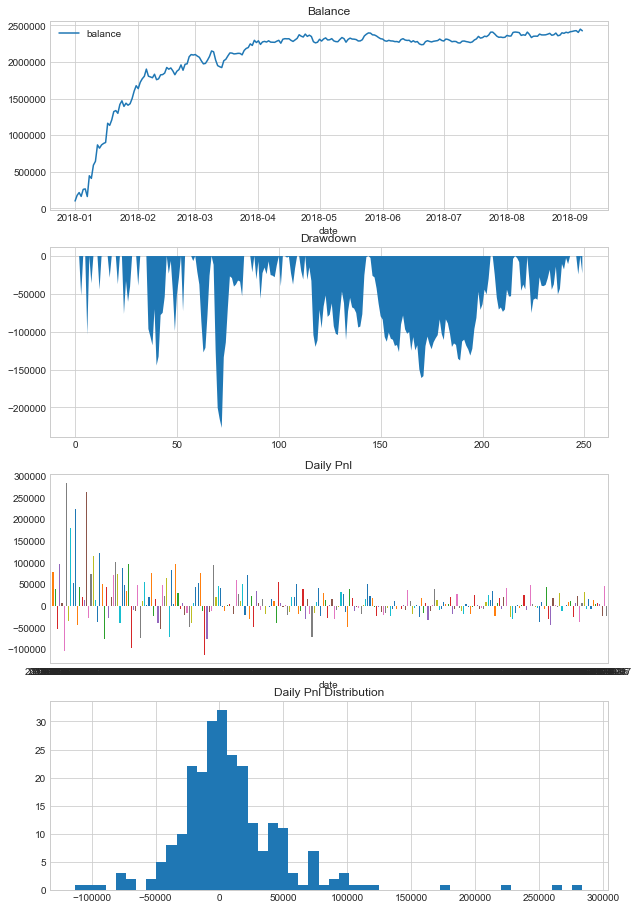

2018-09-09 19:02:21.864356	计算回测结果
单笔盈亏： -2.183020443611555 入场时间： 2018-01-02 07:01:00 开仓价： 13425.71 出场时间 2018-01-02 08:30:00 平仓价： 13700.0 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 5.878615204041764 入场时间： 2018-01-02 09:01:00 开仓价： 13742.53 出场时间 2018-01-02 12:34:00 平仓价： 12915.42 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -0.7729180767135909 入场时间： 2018-01-02 15:01:00 开仓价： 13256.06 出场时间 2018-01-02 16:01:00 平仓价： 13339.96 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 6.1286095010779755 入场时间： 2018-01-02 16:01:00 开仓价： 13339.96 出场时间 2018-01-03 02:25:00 平仓价： 14176.19 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.3279286694101513 入场时间： 2018-01-03 03:01:00 开仓价： 14580.0 出场时间 2018-01-03 03:14:00 平仓价： 14899.0 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.2106098604208 入场时间： 2018-01-03 04:01:00 开仓价： 14775.84 出场时间 2018-01-03 18:02:00 平仓价： 14469.89 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 3.157386976358357 入场时间： 2018-01-03 19:01:00 开仓价： 14466.0 出场时间 2018-01-04 06:01:00 平仓价： 14943.0 交易数量： 1 合约面值： 100 滑点： 0.0

单笔盈亏： 3.3734945256486575 入场时间： 2018-01-19 12:01:00 开仓价： 10817.72 出场时间 2018-01-19 15:01:00 平仓价： 11197.8 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.2528257336262496 入场时间： 2018-01-19 15:01:00 开仓价： 11197.8 出场时间 2018-01-19 16:11:00 平仓价： 11434.39 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.167328553403211 入场时间： 2018-01-19 17:01:00 开仓价： 11428.34 出场时间 2018-01-19 20:07:00 平仓价： 11660.03 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 4.545490882686956 入场时间： 2018-01-19 21:01:00 开仓价： 11720.01 出场时间 2018-01-20 04:01:00 平仓价： 11170.87 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 5.9931838970465074 入场时间： 2018-01-20 04:01:00 开仓价： 11170.87 出场时间 2018-01-20 12:48:00 平仓价： 11856.0 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 5.82483204939689 入场时间： 2018-01-20 13:01:00 开仓价： 12289.03 出场时间 2018-01-21 02:58:00 平仓价： 13022.05 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.1491284263246753 入场时间： 2018-01-21 03:01:00 开仓价： 13034.01 出场时间 2018-01-21 03:47:00 平仓价： 12772.14 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.375797033846

单笔盈亏： -2.442239733404525 入场时间： 2018-02-19 19:01:00 开仓价： 10862.9 出场时间 2018-02-19 23:16:00 平仓价： 11112.99 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 0.5416472694717942 入场时间： 2018-02-20 00:01:00 开仓价： 11170.0 出场时间 2018-02-20 01:01:00 平仓价： 11093.86 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 5.909652690767681 入场时间： 2018-02-20 01:01:00 开仓价： 11093.86 出场时间 2018-02-21 06:22:00 平仓价： 11765.0 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.5859648940123736 入场时间： 2018-02-21 08:01:00 开仓价： 11139.98 出场时间 2018-02-21 08:16:00 平仓价： 10867.5 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.359756127757744 入场时间： 2018-02-21 09:01:00 开仓价： 11065.63 出场时间 2018-02-21 12:03:00 平仓价： 10820.0 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 6.048872696192386 入场时间： 2018-02-21 15:01:00 开仓价： 11068.09 出场时间 2018-02-22 00:34:00 平仓价： 10383.1 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.174800744425361 入场时间： 2018-02-22 03:01:00 开仓价： 10510.12 出场时间 2018-02-22 10:18:00 平仓价： 10723.98 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 5.840072634195826

单笔盈亏： -2.5976601764213765 入场时间： 2018-04-02 04:01:00 开仓价： 6895.99 出场时间 2018-04-02 15:54:00 平仓价： 7065.47 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.166366841784781 入场时间： 2018-04-02 17:01:00 开仓价： 7061.9 出场时间 2018-04-02 22:21:00 平仓价： 6918.8 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 5.972386610623769 入场时间： 2018-04-03 00:01:00 开仓价： 7025.57 出场时间 2018-04-04 02:35:00 平仓价： 7455.0 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.1759063252681132 入场时间： 2018-04-04 04:01:00 开仓价： 7464.98 出场时间 2018-04-04 09:35:00 平仓价： 7313.0 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.313913043478261 入场时间： 2018-04-04 11:01:00 开仓价： 7268.0 出场时间 2018-04-04 17:41:00 平仓价： 7110.0 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 5.872377181735146 入场时间： 2018-04-04 18:01:00 开仓价： 7105.01 出场时间 2018-04-05 09:17:00 平仓价： 6677.83 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.3861805392589632 入场时间： 2018-04-05 10:01:00 开仓价： 6604.99 出场时间 2018-04-05 11:53:00 平仓价： 6753.35 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.211164373428019 入场时间： 2018-

单笔盈亏： 0.2936244541484711 入场时间： 2018-06-12 08:01:00 开仓价： 6870.0 出场时间 2018-06-12 09:01:00 平仓价： 6840.21 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.179995848080687 入场时间： 2018-06-12 09:01:00 开仓价： 6840.21 出场时间 2018-06-12 20:53:00 平仓价： 6700.67 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.1722326339741724 入场时间： 2018-06-12 21:01:00 开仓价： 6697.56 出场时间 2018-06-13 03:08:00 平仓价： 6561.45 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -0.16994011976047627 入场时间： 2018-06-13 07:01:00 开仓价： 6513.0 出场时间 2018-06-15 01:01:00 平仓价： 6514.95 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -0.43961856959761053 入场时间： 2018-06-15 01:01:00 开仓价： 6514.95 出场时间 2018-06-15 22:01:00 平仓价： 6495.43 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -0.5485949659991712 入场时间： 2018-06-15 22:01:00 开仓价： 6495.43 出场时间 2018-06-17 02:01:00 平仓价： 6521.97 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -0.18737832280737485 入场时间： 2018-06-17 02:01:00 开仓价： 6521.97 出场时间 2018-06-18 00:01:00 平仓价： 6518.88 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 0.08672606337284539

单笔盈亏： 3.1567785063984224 入场时间： 2018-08-17 06:01:00 开仓价： 6282.8 出场时间 2018-08-17 15:01:00 平仓价： 6489.93 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -0.18221925352045065 入场时间： 2018-08-17 15:01:00 开仓价： 6489.93 出场时间 2018-08-17 16:01:00 平仓价： 6492.67 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -0.4103048206670011 入场时间： 2018-08-17 16:01:00 开仓价： 6492.67 出场时间 2018-08-17 21:01:00 平仓价： 6475.12 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 0.03652182507814975 入场时间： 2018-08-17 21:01:00 开仓价： 6475.12 出场时间 2018-08-17 23:01:00 平仓价： 6463.69 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.069238561874097 入场时间： 2018-08-17 23:01:00 开仓价： 6463.69 出场时间 2018-08-18 21:47:00 平仓价： 6338.99 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 0.2222885004605676 入场时间： 2018-08-18 23:01:00 开仓价： 6329.21 出场时间 2018-08-19 00:01:00 平仓价： 6352.14 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -0.48822910074399944 入场时间： 2018-08-19 00:01:00 开仓价： 6352.14 出场时间 2018-08-19 19:01:00 平仓价： 6374.26 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 1.3284057443530612 入

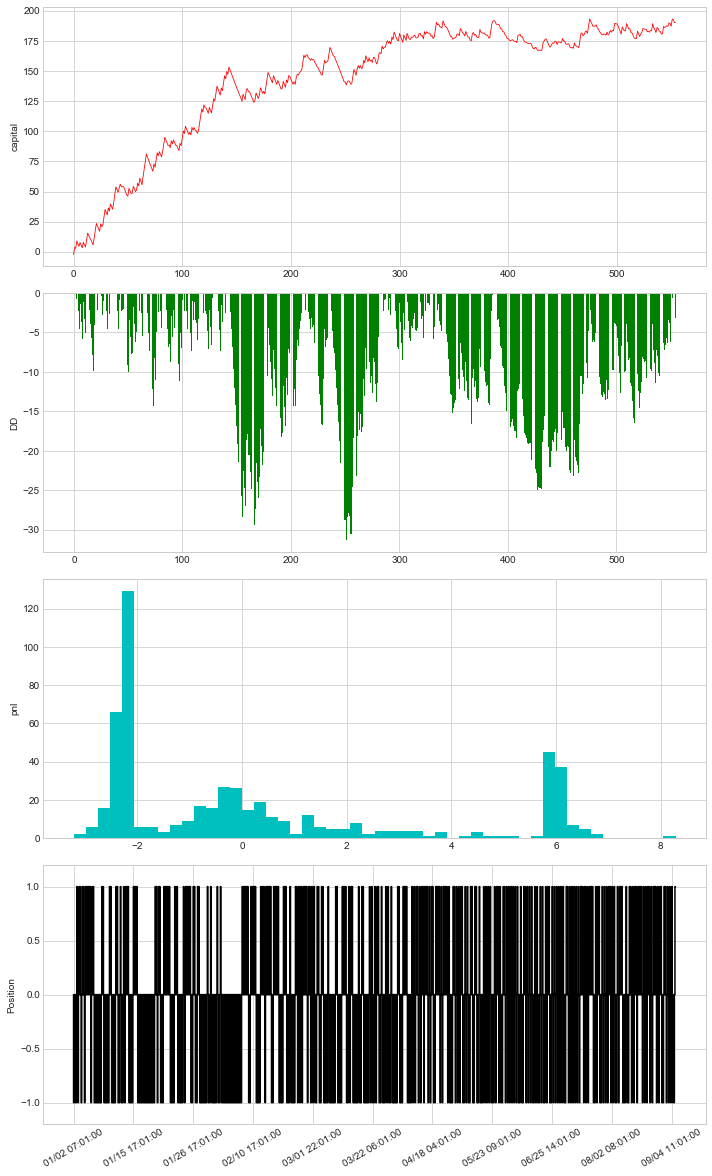

In [13]:
# 显示逐日回测结果
engine.showDailyResult()
# 显示逐笔回测结果
engine.showBacktestingResult()

In [14]:
engine.calculateBacktestingResult()

2018-09-09 19:02:26.526491	计算回测结果
单笔盈亏： -2.183020443611555 入场时间： 2018-01-02 07:01:00 开仓价： 13425.71 出场时间 2018-01-02 08:30:00 平仓价： 13700.0 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 5.878615204041764 入场时间： 2018-01-02 09:01:00 开仓价： 13742.53 出场时间 2018-01-02 12:34:00 平仓价： 12915.42 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -0.7729180767135909 入场时间： 2018-01-02 15:01:00 开仓价： 13256.06 出场时间 2018-01-02 16:01:00 平仓价： 13339.96 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 6.1286095010779755 入场时间： 2018-01-02 16:01:00 开仓价： 13339.96 出场时间 2018-01-03 02:25:00 平仓价： 14176.19 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.3279286694101513 入场时间： 2018-01-03 03:01:00 开仓价： 14580.0 出场时间 2018-01-03 03:14:00 平仓价： 14899.0 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.2106098604208 入场时间： 2018-01-03 04:01:00 开仓价： 14775.84 出场时间 2018-01-03 18:02:00 平仓价： 14469.89 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 3.157386976358357 入场时间： 2018-01-03 19:01:00 开仓价： 14466.0 出场时间 2018-01-04 06:01:00 平仓价： 14943.0 交易数量： 1 合约面值： 100 滑点： 0.0

单笔盈亏： 3.3734945256486575 入场时间： 2018-01-19 12:01:00 开仓价： 10817.72 出场时间 2018-01-19 15:01:00 平仓价： 11197.8 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.2528257336262496 入场时间： 2018-01-19 15:01:00 开仓价： 11197.8 出场时间 2018-01-19 16:11:00 平仓价： 11434.39 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.167328553403211 入场时间： 2018-01-19 17:01:00 开仓价： 11428.34 出场时间 2018-01-19 20:07:00 平仓价： 11660.03 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 4.545490882686956 入场时间： 2018-01-19 21:01:00 开仓价： 11720.01 出场时间 2018-01-20 04:01:00 平仓价： 11170.87 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 5.9931838970465074 入场时间： 2018-01-20 04:01:00 开仓价： 11170.87 出场时间 2018-01-20 12:48:00 平仓价： 11856.0 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 5.82483204939689 入场时间： 2018-01-20 13:01:00 开仓价： 12289.03 出场时间 2018-01-21 02:58:00 平仓价： 13022.05 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.1491284263246753 入场时间： 2018-01-21 03:01:00 开仓价： 13034.01 出场时间 2018-01-21 03:47:00 平仓价： 12772.14 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.375797033846

单笔盈亏： -2.43117370892019 入场时间： 2018-02-18 22:01:00 开仓价： 10650.0 出场时间 2018-02-19 17:49:00 平仓价： 10894.01 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.442239733404525 入场时间： 2018-02-19 19:01:00 开仓价： 10862.9 出场时间 2018-02-19 23:16:00 平仓价： 11112.99 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 0.5416472694717942 入场时间： 2018-02-20 00:01:00 开仓价： 11170.0 出场时间 2018-02-20 01:01:00 平仓价： 11093.86 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 5.909652690767681 入场时间： 2018-02-20 01:01:00 开仓价： 11093.86 出场时间 2018-02-21 06:22:00 平仓价： 11765.0 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.5859648940123736 入场时间： 2018-02-21 08:01:00 开仓价： 11139.98 出场时间 2018-02-21 08:16:00 平仓价： 10867.5 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.359756127757744 入场时间： 2018-02-21 09:01:00 开仓价： 11065.63 出场时间 2018-02-21 12:03:00 平仓价： 10820.0 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 6.048872696192386 入场时间： 2018-02-21 15:01:00 开仓价： 11068.09 出场时间 2018-02-22 00:34:00 平仓价： 10383.1 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.174800744425361 

单笔盈亏： -2.5186414221324043 入场时间： 2018-04-02 01:01:00 开仓价： 6768.99 出场时间 2018-04-02 03:14:00 平仓价： 6930.0 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.5976601764213765 入场时间： 2018-04-02 04:01:00 开仓价： 6895.99 出场时间 2018-04-02 15:54:00 平仓价： 7065.47 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.166366841784781 入场时间： 2018-04-02 17:01:00 开仓价： 7061.9 出场时间 2018-04-02 22:21:00 平仓价： 6918.8 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 5.972386610623769 入场时间： 2018-04-03 00:01:00 开仓价： 7025.57 出场时间 2018-04-04 02:35:00 平仓价： 7455.0 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.1759063252681132 入场时间： 2018-04-04 04:01:00 开仓价： 7464.98 出场时间 2018-04-04 09:35:00 平仓价： 7313.0 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.313913043478261 入场时间： 2018-04-04 11:01:00 开仓价： 7268.0 出场时间 2018-04-04 17:41:00 平仓价： 7110.0 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 5.872377181735146 入场时间： 2018-04-04 18:01:00 开仓价： 7105.01 出场时间 2018-04-05 09:17:00 平仓价： 6677.83 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.3861805392589632 入场时间： 2018-

单笔盈亏： -2.259774681292618 入场时间： 2018-06-12 05:01:00 开仓价： 6746.0 出场时间 2018-06-12 07:38:00 平仓价： 6889.0 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 0.2936244541484711 入场时间： 2018-06-12 08:01:00 开仓价： 6870.0 出场时间 2018-06-12 09:01:00 平仓价： 6840.21 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.179995848080687 入场时间： 2018-06-12 09:01:00 开仓价： 6840.21 出场时间 2018-06-12 20:53:00 平仓价： 6700.67 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.1722326339741724 入场时间： 2018-06-12 21:01:00 开仓价： 6697.56 出场时间 2018-06-13 03:08:00 平仓价： 6561.45 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -0.16994011976047627 入场时间： 2018-06-13 07:01:00 开仓价： 6513.0 出场时间 2018-06-15 01:01:00 平仓价： 6514.95 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -0.43961856959761053 入场时间： 2018-06-15 01:01:00 开仓价： 6514.95 出场时间 2018-06-15 22:01:00 平仓价： 6495.43 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -0.5485949659991712 入场时间： 2018-06-15 22:01:00 开仓价： 6495.43 出场时间 2018-06-17 02:01:00 平仓价： 6521.97 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -0.18737832280737485 入

单笔盈亏： 1.4145259252179176 入场时间： 2018-08-16 18:01:00 开仓价： 6382.01 出场时间 2018-08-17 06:01:00 平仓价： 6282.8 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 3.1567785063984224 入场时间： 2018-08-17 06:01:00 开仓价： 6282.8 出场时间 2018-08-17 15:01:00 平仓价： 6489.93 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -0.18221925352045065 入场时间： 2018-08-17 15:01:00 开仓价： 6489.93 出场时间 2018-08-17 16:01:00 平仓价： 6492.67 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -0.4103048206670011 入场时间： 2018-08-17 16:01:00 开仓价： 6492.67 出场时间 2018-08-17 21:01:00 平仓价： 6475.12 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 0.03652182507814975 入场时间： 2018-08-17 21:01:00 开仓价： 6475.12 出场时间 2018-08-17 23:01:00 平仓价： 6463.69 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.069238561874097 入场时间： 2018-08-17 23:01:00 开仓价： 6463.69 出场时间 2018-08-18 21:47:00 平仓价： 6338.99 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 0.2222885004605676 入场时间： 2018-08-18 23:01:00 开仓价： 6329.21 出场时间 2018-08-19 00:01:00 平仓价： 6352.14 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -0.48822910074399944 入场

{'capital': 190.20698542345056,
 'maxCapital': 193.3510960206217,
 'drawdown': -3.144110597171135,
 'totalResult': 555,
 'totalTurnover': 111000,
 'totalCommission': 55.50000000000052,
 'totalSlippage': 22.199999999999704,
 'timeList': [Timestamp('2018-01-02 08:30:00'),
  Timestamp('2018-01-02 12:34:00'),
  Timestamp('2018-01-02 16:01:00'),
  Timestamp('2018-01-03 02:25:00'),
  Timestamp('2018-01-03 03:14:00'),
  Timestamp('2018-01-03 18:02:00'),
  Timestamp('2018-01-04 06:01:00'),
  Timestamp('2018-01-04 10:05:00'),
  Timestamp('2018-01-04 16:29:00'),
  Timestamp('2018-01-05 03:01:00'),
  Timestamp('2018-01-05 10:07:00'),
  Timestamp('2018-01-05 12:28:00'),
  Timestamp('2018-01-05 17:04:00'),
  Timestamp('2018-01-06 01:34:00'),
  Timestamp('2018-01-06 12:16:00'),
  Timestamp('2018-01-06 21:56:00'),
  Timestamp('2018-01-07 08:01:00'),
  Timestamp('2018-01-07 10:44:00'),
  Timestamp('2018-01-07 21:34:00'),
  Timestamp('2018-01-08 16:56:00'),
  Timestamp('2018-01-08 21:49:00'),
  Timesta